# Ungraded Lab: Using Convolutions with LSTMs

Welcome to the final week of this course! In this lab, you will build upon the RNN models you built last week and append a convolution layer to it. As you saw in previous courses, convolution filters can also capture features from sequences so it's good to try them out when exploring model architectures. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-10-10 14:58:02.339228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 14:58:02.469607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 14:58:02.535380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 14:58:02.561325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 14:58:02.662203: I tensorflow/core/platform/cpu_feature_guar

## Utilities

You will be plotting the MAE and loss later so the `plot_series()` is extended to have more labelling functionality. The utilities for generating the synthetic data is the same as the previous labs.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

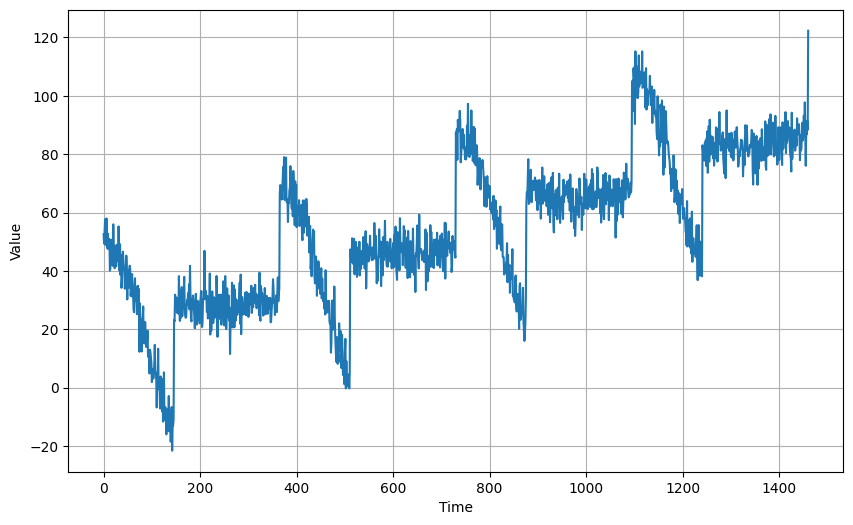

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

As mentioned in the lectures, you can experiment with different batch sizing here and see how it affects your results.

In [5]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

I0000 00:00:1728583086.207687  279618 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583086.442041  279618 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583086.442100  279618 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583086.458036  279618 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583086.458097  279618 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Build the Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [8]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so you can reset it later.

In [9]:
# Get initial weights
init_weights = model.get_weights()

After that, you can tune the model as usual.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-10-10 14:58:11.850827: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728583092.065069  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.106571  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.107653  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.108858  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.125307  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.137081  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.162405  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583092.163393  279741 gpu_t

      6/Unknown 2s 10ms/step - loss: 135.5930

W0000 00:00:1728583093.171731  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.179427  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.185906  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.189834  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.193244  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.196635  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.200250  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.203998  279740 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.207680  279740 gp

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 98.4091 - learning_rate: 1.0000e-08
Epoch 2/100
 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.1469

W0000 00:00:1728583093.883919  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.887647  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.890745  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.893891  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.897020  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.900129  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.903290  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.906471  279741 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583093.909619  279741 gp

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.1775 - learning_rate: 1.1220e-08
Epoch 3/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.6223

2024-10-10 14:58:14.529592: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 14:58:14.529683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:14.529696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:14.529703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:14.529709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:14.529713: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:14.529717: I tensorflow/core/f

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.5979 - learning_rate: 1.2589e-08
Epoch 4/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.2910

2024-10-10 14:58:15.020432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.1989 - learning_rate: 1.4125e-08
Epoch 5/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.8099

2024-10-10 14:58:15.536192: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 14:58:15.536241: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:15.536248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:15.536252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:15.536256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:15.536258: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:15.536261: I tensorflow/core/f

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 17.7727 - learning_rate: 1.5849e-08
Epoch 6/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.5612

2024-10-10 14:58:16.068240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:16.068291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:16.068297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:16.068302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:16.068305: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:16.068307: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.3185 - learning_rate: 1.7783e-08
Epoch 7/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.0787

2024-10-10 14:58:16.544238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:16.544289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:16.544296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:16.544303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.8263 - learning_rate: 1.9953e-08
Epoch 8/100
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.6330

2024-10-10 14:58:17.010506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:17.010553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:17.010561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:17.010566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.3080 - learning_rate: 2.2387e-08
Epoch 9/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.8511

2024-10-10 14:58:17.486818: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 14:58:17.486868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:17.486874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:17.486879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:17.486884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:17.486886: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:17.486889: I tensorflow/core/f

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.7427 - learning_rate: 2.5119e-08
Epoch 10/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.2830

2024-10-10 14:58:17.969390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:17.969439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:17.969446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:17.969451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.1475 - learning_rate: 2.8184e-08
Epoch 11/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.5967

2024-10-10 14:58:18.502065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:18.502120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:18.502127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:18.502132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.5020 - learning_rate: 3.1623e-08
Epoch 12/100
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.1002

2024-10-10 14:58:19.024975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:19.025025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:19.025032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:19.025037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.8276 - learning_rate: 3.5481e-08
Epoch 13/100
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.4654

2024-10-10 14:58:19.523186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:19.523239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:19.523248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:19.523254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:19.523258: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:19.523261: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.1876 - learning_rate: 3.9811e-08
Epoch 14/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.8021

2024-10-10 14:58:20.004446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:20.004493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:20.004499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:20.004504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:20.004507: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:20.004509: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.5484 - learning_rate: 4.4668e-08
Epoch 15/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.2081

2024-10-10 14:58:20.488079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:20.488130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:20.488137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:20.488142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:20.488144: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:20.488147: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.8889 - learning_rate: 5.0119e-08
Epoch 16/100
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.6125

2024-10-10 14:58:20.985784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:20.985828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:20.985835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:20.985840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:20.985843: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:20.985845: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 11.1918 - learning_rate: 5.6234e-08
Epoch 17/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.7778 

2024-10-10 14:58:21.042671: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 14:58:21.042728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:21.042735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:21.042740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:21.042745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.5270 - learning_rate: 6.3096e-08
Epoch 18/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.2061

2024-10-10 14:58:21.559651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:21.559698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:21.559706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:21.559713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:21.559715: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:21.559718: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8748 - learning_rate: 7.0795e-08
Epoch 19/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5857

2024-10-10 14:58:22.129431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:22.129482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:22.129489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:22.129494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.2355 - learning_rate: 7.9433e-08
Epoch 20/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9571

2024-10-10 14:58:22.682170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:22.682249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:22.682258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:22.682267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6324 - learning_rate: 8.9125e-08
Epoch 21/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4985

2024-10-10 14:58:23.343048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:23.343094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:23.343100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:23.343105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:23.343107: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:23.343110: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1029 - learning_rate: 1.0000e-07
Epoch 22/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1020

2024-10-10 14:58:24.016770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:24.016828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:24.016834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:24.016842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6639 - learning_rate: 1.1220e-07
Epoch 23/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7533

2024-10-10 14:58:24.648432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:24.648483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:24.648490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:24.648496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2895 - learning_rate: 1.2589e-07
Epoch 24/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2870

2024-10-10 14:58:25.304724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:25.304768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:25.304775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:25.304780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:25.304783: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:25.304785: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9356 - learning_rate: 1.4125e-07
Epoch 25/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8231

2024-10-10 14:58:25.986853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:25.986905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:25.986911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:25.986916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:25.986919: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:25.986921: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5673 - learning_rate: 1.5849e-07
Epoch 26/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5490

2024-10-10 14:58:26.615347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:26.615411: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:26.615419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:26.615436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3308 - learning_rate: 1.7783e-07
Epoch 27/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3183

2024-10-10 14:58:27.270832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:27.270883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:27.270890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:27.270896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1341 - learning_rate: 1.9953e-07
Epoch 28/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1644

2024-10-10 14:58:27.902538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:27.902582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:27.902589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:27.902595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:27.902597: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:27.902599: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0274 - learning_rate: 2.2387e-07
Epoch 29/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1447

2024-10-10 14:58:28.557361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:28.557408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:28.557415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:28.557420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:28.557422: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:28.557425: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9863 - learning_rate: 2.5119e-07
Epoch 30/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0926 

2024-10-10 14:58:29.205327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:29.205374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:29.205381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:29.205386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9690 - learning_rate: 2.8184e-07
Epoch 31/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8955

2024-10-10 14:58:29.782633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:29.782678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:29.782685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:29.782704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:29.782706: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:29.782708: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8749 - learning_rate: 3.1623e-07
Epoch 32/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5299

2024-10-10 14:58:30.400584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:30.400660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:30.400669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:30.400674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4653 - learning_rate: 3.5481e-07
Epoch 33/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4637

2024-10-10 14:58:31.044278: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 14:58:31.044338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:31.044347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:31.044354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:31.044361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:31.044365: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:31.044369: I tensorflow/core/f

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5787 - learning_rate: 3.9811e-07
Epoch 34/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4457

2024-10-10 14:58:31.673377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:31.673432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:31.673439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:31.673446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:31.673448: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:31.673451: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0209 - learning_rate: 4.4668e-07
Epoch 35/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9979

2024-10-10 14:58:32.308199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:32.308250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:32.308257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:32.308262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5706 - learning_rate: 5.0119e-07
Epoch 36/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1908

2024-10-10 14:58:32.944791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:32.944849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:32.944856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:32.944861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6470 - learning_rate: 5.6234e-07
Epoch 37/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2519

2024-10-10 14:58:33.593835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:33.593889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:33.593897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:33.593903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7662 - learning_rate: 6.3096e-07
Epoch 38/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2198

2024-10-10 14:58:34.232528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:34.232576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:34.232583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:34.232589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:34.232592: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:34.232594: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8169 - learning_rate: 7.0795e-07
Epoch 39/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0853

2024-10-10 14:58:34.876126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:34.876206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:34.876224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:34.876228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7431 - learning_rate: 7.9433e-07
Epoch 40/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2446

2024-10-10 14:58:35.466726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:35.466776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:35.466784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:35.466798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8776 - learning_rate: 8.9125e-07
Epoch 41/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4527

2024-10-10 14:58:36.097164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:36.097218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:36.097226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:36.097231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7924 - learning_rate: 1.0000e-06
Epoch 42/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9744

2024-10-10 14:58:36.717819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:36.717868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:36.717876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:36.717882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7626 - learning_rate: 1.1220e-06
Epoch 43/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7542

2024-10-10 14:58:37.398590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:37.398646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:37.398653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:37.398658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8199 - learning_rate: 1.2589e-06
Epoch 44/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1219

2024-10-10 14:58:38.029161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:38.029209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:38.029216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:38.029221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:38.029223: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:38.029226: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3418 - learning_rate: 1.4125e-06
Epoch 45/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6625

2024-10-10 14:58:38.733195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:38.733251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:38.733258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:38.733263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:38.733265: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:38.733268: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6920 - learning_rate: 1.5849e-06
Epoch 46/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4211

2024-10-10 14:58:39.367586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:39.367651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:39.367659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:39.367665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:39.367668: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:39.367671: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4995 - learning_rate: 1.7783e-06
Epoch 47/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0627 

2024-10-10 14:58:39.987059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:39.987117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:39.987123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:39.987129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.9531 - learning_rate: 1.9953e-06
Epoch 48/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5314

2024-10-10 14:58:40.602937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:40.602987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:40.602995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:40.602999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:40.603002: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:40.603004: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.9980 - learning_rate: 2.2387e-06
Epoch 49/100
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0848

2024-10-10 14:58:41.246622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:41.246669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:41.246675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:41.246681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:41.246683: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:41.246686: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2967 - learning_rate: 2.5119e-06
Epoch 50/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4821

2024-10-10 14:58:41.900731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:41.900786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:41.900794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:41.900799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:41.900801: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:41.900803: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6579 - learning_rate: 2.8184e-06
Epoch 51/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1430

2024-10-10 14:58:42.532393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:42.532445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:42.532451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:42.532458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.6224 - learning_rate: 3.1623e-06
Epoch 52/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5691 

2024-10-10 14:58:43.202446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:43.202493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:43.202500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:43.202505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:43.202507: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:43.202509: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5647 - learning_rate: 3.5481e-06
Epoch 53/100
10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3147

2024-10-10 14:58:43.802487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:43.802581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:43.802589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:43.802595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3571 - learning_rate: 3.9811e-06
Epoch 54/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3713

2024-10-10 14:58:44.456475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:44.456536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:44.456545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:44.456551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5807 - learning_rate: 4.4668e-06
Epoch 55/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8495

2024-10-10 14:58:45.083104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:45.083159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:45.083166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:45.083171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1636 - learning_rate: 5.0119e-06
Epoch 56/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4764

2024-10-10 14:58:45.731025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:45.731089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:45.731099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:45.731108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.9429 - learning_rate: 5.6234e-06
Epoch 57/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7165

2024-10-10 14:58:46.300402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:46.300455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:46.300461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:46.300467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.7832 - learning_rate: 6.3096e-06
Epoch 58/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1705

2024-10-10 14:58:46.930332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:46.930382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:46.930389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:46.930395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6291 - learning_rate: 7.0795e-06
Epoch 59/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7155

2024-10-10 14:58:47.505217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:47.505271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:47.505279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:47.505284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7351 - learning_rate: 7.9433e-06
Epoch 60/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9606

2024-10-10 14:58:48.053784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:48.053838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:48.053846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:48.053851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:48.053853: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:48.053856: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9508 - learning_rate: 8.9125e-06
Epoch 61/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.3054

2024-10-10 14:58:48.610536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:48.610607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:48.610615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:48.610637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.9198 - learning_rate: 1.0000e-05
Epoch 62/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.6837

2024-10-10 14:58:49.143782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:49.143830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:49.143839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:49.143845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:49.143847: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:49.143850: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.1962 - learning_rate: 1.1220e-05
Epoch 63/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3168

2024-10-10 14:58:49.699848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:49.699900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:49.699908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:49.699914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0633 - learning_rate: 1.2589e-05
Epoch 64/100
10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.2454

2024-10-10 14:58:50.321459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:50.321568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:50.321587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:50.321600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2932 - learning_rate: 1.4125e-05
Epoch 65/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5891

2024-10-10 14:58:51.059215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:51.059281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:51.059289: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_13]]
2024-10-10 14:58:51.059330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:51.059339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0609 - learning_rate: 1.5849e-05
Epoch 66/100
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.0846

2024-10-10 14:58:51.684404: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:51.684451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:51.684457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:51.684463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:51.684466: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:51.684468: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.4360 - learning_rate: 1.7783e-05
Epoch 67/100
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7438

2024-10-10 14:58:52.340057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:52.340113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:52.340120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:52.340126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.9800 - learning_rate: 1.9953e-05
Epoch 68/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.4856

2024-10-10 14:58:53.003574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:53.003628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:53.003634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:53.003639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:53.003642: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:53.003644: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2164 - learning_rate: 2.2387e-05
Epoch 69/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4175

2024-10-10 14:58:53.113276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:53.113331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:53.113338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:53.113343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6011 - learning_rate: 2.5119e-05
Epoch 70/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2545

2024-10-10 14:58:53.611120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:53.611176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:53.611183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:53.611189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:53.611192: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:53.611194: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2775 - learning_rate: 2.8184e-05
Epoch 71/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4121 

2024-10-10 14:58:54.148651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:54.148704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:54.148712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:54.148717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:54.148719: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:54.148722: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.9411 - learning_rate: 3.1623e-05
Epoch 72/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8529

2024-10-10 14:58:54.786953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:54.786999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:54.787007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:54.787020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4739 - learning_rate: 3.5481e-05
Epoch 73/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1285 

2024-10-10 14:58:55.463000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:55.463063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:55.463071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:55.463077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:55.463079: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:55.463081: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.8824 - learning_rate: 3.9811e-05
Epoch 74/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7959

2024-10-10 14:58:56.063255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:56.063309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:56.063316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:56.063321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:56.063324: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:56.063325: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5193 - learning_rate: 4.4668e-05
Epoch 75/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9725

2024-10-10 14:58:56.725108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:56.725154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:56.725161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:56.725166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6320 - learning_rate: 5.0119e-05
Epoch 76/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1408

2024-10-10 14:58:57.353663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:57.353724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:57.353734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:57.353743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0770 - learning_rate: 5.6234e-05
Epoch 77/100
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.7792

2024-10-10 14:58:57.907438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:57.907494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:57.907501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:57.907506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.7631 - learning_rate: 6.3096e-05
Epoch 78/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2022

2024-10-10 14:58:58.441643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:58.441702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:58.441708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:58.441714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:58:58.441717: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:58:58.441719: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5671 - learning_rate: 7.0795e-05
Epoch 79/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0569

2024-10-10 14:58:58.968896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:58.968945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:58.968952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:58.968956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3436 - learning_rate: 7.9433e-05
Epoch 80/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4958

2024-10-10 14:58:59.512639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:58:59.512702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:58:59.512711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:58:59.512717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5577 - learning_rate: 8.9125e-05
Epoch 81/100
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.8175

2024-10-10 14:59:00.220568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:00.220626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:00.220634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:00.220640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:59:00.220645: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:59:00.220648: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.9529 - learning_rate: 1.0000e-04
Epoch 82/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2200 

2024-10-10 14:59:00.876514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:00.876599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:00.876614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:00.876624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.9537 - learning_rate: 1.1220e-04
Epoch 83/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.3006

2024-10-10 14:59:01.460645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:01.460731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:01.460745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:01.460754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.8031 - learning_rate: 1.2589e-04
Epoch 84/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4436

2024-10-10 14:59:02.043014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:02.043061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:02.043070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:02.043078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:59:02.043082: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:59:02.043085: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12.0938 - learning_rate: 1.4125e-04
Epoch 85/100
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.2083

2024-10-10 14:59:02.690899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:02.690953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:02.690960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:02.690966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:59:02.690969: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:59:02.690971: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.6397 - learning_rate: 1.5849e-04
Epoch 86/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.5799 

2024-10-10 14:59:03.241892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:03.241946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:03.241954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:03.241959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.6511 - learning_rate: 1.7783e-04
Epoch 87/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.5932

2024-10-10 14:59:03.817632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:03.817703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:03.817715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:03.817724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 16.2918 - learning_rate: 1.9953e-04
Epoch 88/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 28.0942

2024-10-10 14:59:04.396676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:04.396741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 29.3019 - learning_rate: 2.2387e-04
Epoch 89/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.5574

2024-10-10 14:59:04.935593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:04.935641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:04.935649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:04.935654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 22.4195 - learning_rate: 2.5119e-04
Epoch 90/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27.3960

2024-10-10 14:59:05.467772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:59:05.467841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:05.467863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:05.467867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 27.3126 - learning_rate: 2.8184e-04
Epoch 91/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.7633

2024-10-10 14:59:05.978488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:05.978538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:05.978545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:05.978551: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.7410 - learning_rate: 3.1623e-04
Epoch 92/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 25.4620

2024-10-10 14:59:06.569364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:59:06.569453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:06.569484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:06.569498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 26.7885 - learning_rate: 3.5481e-04
Epoch 93/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 26.2553

2024-10-10 14:59:07.176726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:07.176779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:07.176786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:07.176792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 30.1026 - learning_rate: 3.9811e-04
Epoch 94/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.2730

2024-10-10 14:59:07.759479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:07.759527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:07.759534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:07.759539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050
2024-10-10 14:59:07.759541: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8338041041284736390
2024-10-10 14:59:07.759543: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4749752385045499608


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 36.4768 - learning_rate: 4.4668e-04
Epoch 95/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.9416

2024-10-10 14:59:08.289398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:08.289455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:08.289464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:08.289471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.3106 - learning_rate: 5.0119e-04
Epoch 96/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74.2496

2024-10-10 14:59:08.797222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:08.797267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:08.797273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:08.797278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 84.0077 - learning_rate: 5.6234e-04
Epoch 97/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 63.5538

2024-10-10 14:59:09.352426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:09.352488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:09.352508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:09.352514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 61.1721 - learning_rate: 6.3096e-04
Epoch 98/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 105.0354 

2024-10-10 14:59:09.829768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:09.829822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:09.829830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:09.829836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 105.5938 - learning_rate: 7.0795e-04
Epoch 99/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 43.5108

2024-10-10 14:59:10.382080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:10.382137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:10.382147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:10.382152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 55.9606 - learning_rate: 7.9433e-04
Epoch 100/100
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 86.1022

2024-10-10 14:59:10.938669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:10.938714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:10.938721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:10.938726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 98.0705 - learning_rate: 8.9125e-04


2024-10-10 14:59:11.489461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 792351771118489925
2024-10-10 14:59:11.489511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3600010222796057301
2024-10-10 14:59:11.489518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16425041575281202509
2024-10-10 14:59:11.489523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 523913015196906050


(1e-08, 0.001, 0.0, 50.0)

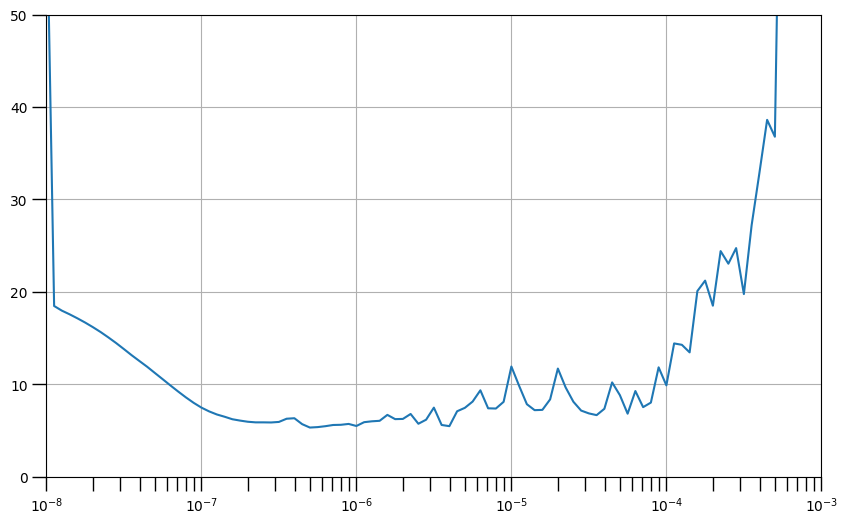

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

To reset the weights, you can simply call the [`set_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights) and pass in the saved weights from earlier.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

Then you can set the training parameters and start training.

In [13]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 54.3446 - mae: 54.8399
Epoch 2/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.9484 - mae: 15.4417

2024-10-10 14:59:13.393278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:13.393328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:13.393334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:13.393339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.5598 - mae: 15.0503
Epoch 3/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.7170 - mae: 13.2017

2024-10-10 14:59:13.976562: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:13.976623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:13.976631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:13.976638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:13.976642: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:13.976647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.3078 - mae: 12.7951
Epoch 4/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.1092 - mae: 11.5912

2024-10-10 14:59:14.493772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:14.493818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:14.493824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:14.493829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.5661 - mae: 11.0509
Epoch 5/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7127 - mae: 10.1972

2024-10-10 14:59:14.990423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:14.990474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:14.990482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:14.990487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1991 - mae: 9.6808
Epoch 6/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8505 - mae: 9.3394

2024-10-10 14:59:15.498716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3436 - mae: 8.8289
Epoch 7/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2806 - mae: 8.7665

2024-10-10 14:59:16.023438: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:16.023493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:16.023499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:16.023503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:16.023506: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:16.023511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.7882 - mae: 8.2717
Epoch 8/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8665 - mae: 8.3540

2024-10-10 14:59:16.606068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:16.606120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:16.606127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:16.606134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3762 - mae: 7.8593
Epoch 9/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0188 - mae: 7.5014
Epoch 10/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1933 - mae: 7.6761

2024-10-10 14:59:17.763636: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:17.763684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:17.763691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:17.763696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:17.763698: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:17.763703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6983 - mae: 7.1787
Epoch 11/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9002 - mae: 7.3798

2024-10-10 14:59:18.262543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:18.262611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:18.262617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:18.262643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4020 - mae: 6.8810
Epoch 12/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6388 - mae: 7.1223

2024-10-10 14:59:18.812598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:18.812652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:18.812662: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:18.812669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1760 - mae: 6.6582
Epoch 13/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4499 - mae: 6.9339

2024-10-10 14:59:19.314583: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:19.314638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:19.314645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:19.314650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:19.314652: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:19.314657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0363 - mae: 6.5181
Epoch 14/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3128 - mae: 6.7983

2024-10-10 14:59:19.871402: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:19.871464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:19.871472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:19.871479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:19.871481: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:19.871486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9242 - mae: 6.4074
Epoch 15/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1833 - mae: 6.6655

2024-10-10 14:59:20.406328: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:20.406376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:20.406382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:20.406386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:20.406389: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:20.406393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8372 - mae: 6.3170
Epoch 16/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0867 - mae: 6.5674

2024-10-10 14:59:20.965419: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:20.965469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:20.965475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:20.965479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:20.965482: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:20.965487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7495 - mae: 6.2279
Epoch 17/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0103 - mae: 6.4890

2024-10-10 14:59:21.512527: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:21.512577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:21.512583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:21.512587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:21.512589: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:21.512593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6888 - mae: 6.1665
Epoch 18/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9491 - mae: 6.4289

2024-10-10 14:59:22.055815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:22.055865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:22.055873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:22.055878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6430 - mae: 6.1207
Epoch 19/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8570 - mae: 6.3313

2024-10-10 14:59:22.599020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:22.599071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:22.599077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:22.599082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5859 - mae: 6.0603
Epoch 20/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8116 - mae: 6.2846

2024-10-10 14:59:23.160396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:23.160446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:23.160453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:23.160458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5512 - mae: 6.0254
Epoch 21/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5258 - mae: 6.0004
Epoch 22/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7661 - mae: 6.2390

2024-10-10 14:59:24.223317: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:24.223371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:24.223379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:24.223384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:24.223388: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:24.223394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4952 - mae: 5.9696
Epoch 23/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7453 - mae: 6.2168

2024-10-10 14:59:24.698538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:24.698600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:24.698608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:24.698614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ -0s -252us/step - loss: 5.4810 - mae: 5.9552
Epoch 24/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7031 - mae: 6.1749

2024-10-10 14:59:24.698364: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:24.698416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:24.698422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:24.698426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:24.698428: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:24.698434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4504 - mae: 5.9252
Epoch 25/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6715 - mae: 6.1432

2024-10-10 14:59:25.202746: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:25.202802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:25.202808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:25.202812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:25.202815: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:25.202819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4319 - mae: 5.9065
Epoch 26/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6535 - mae: 6.1259

2024-10-10 14:59:25.742715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:25.742763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:25.742770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:25.742775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4046 - mae: 5.8796
Epoch 27/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6188 - mae: 6.0896

2024-10-10 14:59:26.246574: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:26.246624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:26.246631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:26.246636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:26.246638: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:26.246643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3883 - mae: 5.8625
Epoch 28/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6117 - mae: 6.0845

2024-10-10 14:59:26.745455: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:26.745504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:26.745510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:26.745514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:26.745517: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:26.745521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3786 - mae: 5.8539
Epoch 29/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6013 - mae: 6.0766

2024-10-10 14:59:27.256845: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:27.256894: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/Shape_9/_10]]
2024-10-10 14:59:27.256901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:27.256905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:27.256909: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:27.256912: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1425823810

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3662 - mae: 5.8428
Epoch 30/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6091 - mae: 6.0872

2024-10-10 14:59:27.771531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:27.771580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:27.771587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:27.771594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3637 - mae: 5.8416
Epoch 31/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3267 - mae: 5.8035
Epoch 32/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5148 - mae: 5.9880 

2024-10-10 14:59:28.955464: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:28.955513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:28.955519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:28.955523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:28.955526: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:28.955531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3129 - mae: 5.7896
Epoch 33/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4921 - mae: 5.9628

2024-10-10 14:59:29.627330: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:29.627381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:29.627387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:29.627391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:29.627394: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:29.627398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3025 - mae: 5.7777
Epoch 34/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5098 - mae: 5.9810

2024-10-10 14:59:30.189842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:30.189890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:30.189897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:30.189902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2922 - mae: 5.7668
Epoch 35/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4679 - mae: 5.9382

2024-10-10 14:59:30.733860: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:30.733912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:30.733918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:30.733922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:30.733925: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:30.733930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2786 - mae: 5.7530
Epoch 36/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4384 - mae: 5.9104

2024-10-10 14:59:31.279211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:31.279265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:31.279272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:31.279277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2597 - mae: 5.7348
Epoch 37/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4540 - mae: 5.9257

2024-10-10 14:59:31.844913: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:31.844964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:31.844972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:31.844997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:31.845003: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:31.845009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2511 - mae: 5.7259
Epoch 38/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4167 - mae: 5.8876

2024-10-10 14:59:32.392686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:32.392732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:32.392748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:32.392754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2422 - mae: 5.7162
Epoch 39/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4092 - mae: 5.8784

2024-10-10 14:59:32.988960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:32.989000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:32.989006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:32.989012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2342 - mae: 5.7073
Epoch 40/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3990 - mae: 5.8696

2024-10-10 14:59:33.620918: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:33.620967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:33.620973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:33.620978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:33.620980: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:33.620985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2241 - mae: 5.6983
Epoch 41/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3930 - mae: 5.8630

2024-10-10 14:59:34.342173: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:34.342227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:34.342233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:34.342238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:34.342241: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:34.342245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2145 - mae: 5.6884
Epoch 42/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2010 - mae: 5.6738
Epoch 43/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3694 - mae: 5.8386

2024-10-10 14:59:35.583453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:35.583503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:35.583510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:35.583515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1931 - mae: 5.6666
Epoch 44/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3593 - mae: 5.8289

2024-10-10 14:59:36.277318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1878 - mae: 5.6608
Epoch 45/500
13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3563 - mae: 5.8264

2024-10-10 14:59:36.932283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:36.932333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:36.932340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:36.932344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1770 - mae: 5.6508
Epoch 46/500
10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3024 - mae: 5.7719

2024-10-10 14:59:37.703305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1694 - mae: 5.6435
Epoch 47/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3343 - mae: 5.8049

2024-10-10 14:59:38.400747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:38.400793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1640 - mae: 5.6375
Epoch 48/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3364 - mae: 5.8063

2024-10-10 14:59:39.058319: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:39.058376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:39.058382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:39.058387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:39.058389: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:39.058394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1540 - mae: 5.6280
Epoch 49/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1403 - mae: 5.6142
Epoch 50/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1418 - mae: 5.6153
Epoch 51/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3365 - mae: 5.8069

2024-10-10 14:59:40.749681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1334 - mae: 5.6063
Epoch 52/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1321 - mae: 5.6067
Epoch 53/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3072 - mae: 5.7790

2024-10-10 14:59:41.876740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1240 - mae: 5.5994
Epoch 54/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2814 - mae: 5.7548

2024-10-10 14:59:42.530965: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:42.531015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:42.531021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:42.531025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:42.531027: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:42.531031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1115 - mae: 5.5870
Epoch 55/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2779 - mae: 5.7483

2024-10-10 14:59:43.171846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:43.171914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:43.171924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:43.171931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1062 - mae: 5.5799
Epoch 56/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1037 - mae: 5.5782
Epoch 57/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2516 - mae: 5.7240

2024-10-10 14:59:44.582957: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:44.583016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:44.583022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:44.583028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:44.583031: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:44.583036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0885 - mae: 5.5625
Epoch 58/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2406 - mae: 5.7143

2024-10-10 14:59:45.300072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:45.300131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0750 - mae: 5.5498
Epoch 59/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0798 - mae: 5.5540
Epoch 60/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2330 - mae: 5.7070

2024-10-10 14:59:46.771739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:46.771786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:46.771795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:46.771801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0655 - mae: 5.5406
Epoch 61/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0550 - mae: 5.5293
Epoch 62/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2059 - mae: 5.6756

2024-10-10 14:59:48.029024: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886
2024-10-10 14:59:48.029085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:48.029104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:48.029108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0423 - mae: 5.5156
Epoch 63/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2008 - mae: 5.6733

2024-10-10 14:59:48.688171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:48.688218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:48.688225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:48.688229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0427 - mae: 5.5162
Epoch 64/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1964 - mae: 5.6696

2024-10-10 14:59:49.337880: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:49.337929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:49.337935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:49.337940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:49.337942: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:49.337947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0324 - mae: 5.5062
Epoch 65/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0376 - mae: 5.5129
Epoch 66/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1952 - mae: 5.6697

2024-10-10 14:59:50.683572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:50.683610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:50.683617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:50.683622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0272 - mae: 5.5020
Epoch 67/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1808 - mae: 5.6546

2024-10-10 14:59:51.382082: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:51.382129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:51.382135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:51.382140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:51.382143: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:51.382147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0169 - mae: 5.4909
Epoch 68/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1717 - mae: 5.6463

2024-10-10 14:59:52.039041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:52.039087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:52.039095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:52.039099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0110 - mae: 5.4857
Epoch 69/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1790 - mae: 5.6550

2024-10-10 14:59:52.698676: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:52.698717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:52.698723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:52.698728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:52.698730: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:52.698735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0124 - mae: 5.4879
Epoch 70/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1725 - mae: 5.6492

2024-10-10 14:59:53.375456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:53.375501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:53.375507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:53.375513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0070 - mae: 5.4833
Epoch 71/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1519 - mae: 5.6256

2024-10-10 14:59:54.007827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:54.007871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:54.007878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:54.007883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9931 - mae: 5.4676
Epoch 72/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1635 - mae: 5.6405

2024-10-10 14:59:54.674069: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:54.674118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:54.674124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:54.674128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:54.674130: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:54.674134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9987 - mae: 5.4752
Epoch 73/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1557 - mae: 5.6315

2024-10-10 14:59:55.372105: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 14:59:55.372159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:55.372165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:55.372170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:55.372172: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 14:59:55.372176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9950 - mae: 5.4704
Epoch 74/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1434 - mae: 5.6192

2024-10-10 14:59:56.036313: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:56.036359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:56.036366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:56.036371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9828 - mae: 5.4590
Epoch 75/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1417 - mae: 5.6187

2024-10-10 14:59:56.734088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:56.734136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:56.734200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:56.734207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9759 - mae: 5.4527
Epoch 76/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9668 - mae: 5.4440
Epoch 77/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1330 - mae: 5.6110

2024-10-10 14:59:58.014478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:58.014528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:58.014535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:58.014541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9664 - mae: 5.4439
Epoch 78/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1234 - mae: 5.6014

2024-10-10 14:59:58.695598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:58.695652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:58.695658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886
2024-10-10 14:59:58.695693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:58.695699: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9614 - mae: 5.4391
Epoch 79/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1407 - mae: 5.6190

2024-10-10 14:59:59.342493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:59.342540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:59.342547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:59.342552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9674 - mae: 5.4453
Epoch 80/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1233 - mae: 5.6019

2024-10-10 14:59:59.965338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 14:59:59.965378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 14:59:59.965385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 14:59:59.965393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9573 - mae: 5.4352
Epoch 81/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9542 - mae: 5.4325
Epoch 82/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1062 - mae: 5.5843

2024-10-10 15:00:01.321108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9402 - mae: 5.4180
Epoch 83/500
13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1026 - mae: 5.5795

2024-10-10 15:00:01.985962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:01.985999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:01.986006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9426 - mae: 5.4206
Epoch 84/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0999 - mae: 5.5788

2024-10-10 15:00:02.729315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:02.729359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:02.729365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:02.729371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9337 - mae: 5.4116
Epoch 85/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0804 - mae: 5.5586

2024-10-10 15:00:03.382808: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:03.382859: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:03.382865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:03.382870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:03.382872: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:03.382877: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9275 - mae: 5.4052
Epoch 86/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.9230 - mae: 5.4007
Epoch 87/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0692 - mae: 5.5471

2024-10-10 15:00:04.740016: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:04.740060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:04.740066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:04.740070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:04.740073: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:04.740077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9101 - mae: 5.3875
Epoch 88/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0692 - mae: 5.5477

2024-10-10 15:00:05.387003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:05.387053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:05.387059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:05.387066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9082 - mae: 5.3859
Epoch 89/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0633 - mae: 5.5415

2024-10-10 15:00:06.035732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:06.035774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:06.035782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:06.035787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8978 - mae: 5.3752
Epoch 90/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0459 - mae: 5.5235

2024-10-10 15:00:06.648344: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:06.648390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:06.648396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:06.648400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:06.648402: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:06.648407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8929 - mae: 5.3701
Epoch 91/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8929 - mae: 5.3688
Epoch 92/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0474 - mae: 5.5264

2024-10-10 15:00:07.896381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:07.896439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:07.896446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:07.896452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8946 - mae: 5.3722
Epoch 93/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0486 - mae: 5.5283

2024-10-10 15:00:08.543190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:08.543235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:08.543242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:08.543247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8942 - mae: 5.3721
Epoch 94/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0393 - mae: 5.5190

2024-10-10 15:00:09.184673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:09.184718: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:09.184725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:09.184730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8898 - mae: 5.3680
Epoch 95/500
12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9882 - mae: 5.4648

2024-10-10 15:00:09.836323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:09.836398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:09.836407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8731 - mae: 5.3503
Epoch 96/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0151 - mae: 5.4914

2024-10-10 15:00:10.529096: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:10.529139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:10.529144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:10.529148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:10.529151: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:10.529155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8696 - mae: 5.3460
Epoch 97/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0149 - mae: 5.4933

2024-10-10 15:00:11.178786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:11.178835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:11.178842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:11.178847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8681 - mae: 5.3458
Epoch 98/500
62/62 ━━━━━━━━━━━━━━━━━━━━ -0s -1023us/step - loss: 4.8608 - mae: 5.3382
Epoch 99/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9904 - mae: 5.4668

2024-10-10 15:00:11.761837: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:11.761889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:11.761895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:11.761900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:11.761902: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:11.761907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8524 - mae: 5.3297
Epoch 100/500
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9493 - mae: 5.4266

2024-10-10 15:00:12.459888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:12.459935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:12.459942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:12.459948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8525 - mae: 5.3306
Epoch 101/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8517 - mae: 5.3300
Epoch 102/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8447 - mae: 5.3223
Epoch 103/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9809 - mae: 5.4587

2024-10-10 15:00:14.517320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:14.517385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:14.517395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:14.517400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8404 - mae: 5.3180
Epoch 104/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9744 - mae: 5.4515

2024-10-10 15:00:15.186357: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:15.186407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:15.186414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:15.186418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:15.186420: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:15.186425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8324 - mae: 5.3095
Epoch 105/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8309 - mae: 5.3080
Epoch 106/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9664 - mae: 5.4444

2024-10-10 15:00:16.533028: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:16.533078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:16.533084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:16.533088: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:16.533090: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:16.533095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8350 - mae: 5.3129
Epoch 107/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9663 - mae: 5.4442

2024-10-10 15:00:17.161925: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:17.161966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:17.161972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:17.161976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:17.161979: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:17.161983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8284 - mae: 5.3059
Epoch 108/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9591 - mae: 5.4381

2024-10-10 15:00:17.835156: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:17.835204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:17.835210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:17.835214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:17.835216: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:17.835220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8283 - mae: 5.3068
Epoch 109/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8096 - mae: 5.2873
Epoch 110/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9423 - mae: 5.4182

2024-10-10 15:00:19.200268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:19.200314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:19.200320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:19.200325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8031 - mae: 5.2795
Epoch 111/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9405 - mae: 5.4178

2024-10-10 15:00:19.861017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:19.861068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:19.861080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:19.861085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8008 - mae: 5.2778
Epoch 112/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9407 - mae: 5.4187

2024-10-10 15:00:20.556043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:20.556085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:20.556092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:20.556097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8063 - mae: 5.2835
Epoch 113/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8086 - mae: 5.2858
Epoch 114/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9327 - mae: 5.4115

2024-10-10 15:00:21.932201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:21.932250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:21.932257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:21.932262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7984 - mae: 5.2767
Epoch 115/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7923 - mae: 5.2710
Epoch 116/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9298 - mae: 5.4094

2024-10-10 15:00:23.264623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7945 - mae: 5.2730
Epoch 117/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9124 - mae: 5.3898

2024-10-10 15:00:23.893444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:23.893488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:23.893494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:23.893499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7808 - mae: 5.2588
Epoch 118/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8923 - mae: 5.3691

2024-10-10 15:00:24.560244: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:24.560295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:24.560302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:24.560307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:24.560310: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:24.560314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7835 - mae: 5.2621
Epoch 119/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9132 - mae: 5.3916

2024-10-10 15:00:25.274292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:25.274334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:25.274341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:25.274346: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7818 - mae: 5.2602
Epoch 120/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7721 - mae: 5.2507
Epoch 121/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8907 - mae: 5.3681

2024-10-10 15:00:26.634692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:26.634735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:26.634742: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:26.634746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7734 - mae: 5.2519
Epoch 122/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8936 - mae: 5.3716

2024-10-10 15:00:27.250138: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:27.250192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:27.250198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:27.250202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:27.250205: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:27.250210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7758 - mae: 5.2545
Epoch 123/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8991 - mae: 5.3785

2024-10-10 15:00:27.885392: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:27.885441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:27.885447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:27.885452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:27.885455: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:27.885459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7714 - mae: 5.2507
Epoch 124/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8924 - mae: 5.3711

2024-10-10 15:00:28.554753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:28.554788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:28.554795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:28.554800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7652 - mae: 5.2443
Epoch 125/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7640 - mae: 5.2427
Epoch 126/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8883 - mae: 5.3678

2024-10-10 15:00:29.872330: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:29.872373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:29.872379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:29.872384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:29.872386: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:29.872391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7615 - mae: 5.2407
Epoch 127/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8801 - mae: 5.3590 

2024-10-10 15:00:30.508200: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:30.508245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:30.508251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:30.508255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:30.508258: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:30.508262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7531 - mae: 5.2318
Epoch 128/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8767 - mae: 5.3540

2024-10-10 15:00:31.137174: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:31.137221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:31.137227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:31.137232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:31.137234: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:31.137238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7535 - mae: 5.2317
Epoch 129/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8770 - mae: 5.3555

2024-10-10 15:00:31.741484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:31.741535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7524 - mae: 5.2311
Epoch 130/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7470 - mae: 5.2253
Epoch 131/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7503 - mae: 5.2289
Epoch 132/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8763 - mae: 5.3556

2024-10-10 15:00:33.695584: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:33.695627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:33.695633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:33.695637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:33.695640: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:33.695644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7541 - mae: 5.2334
Epoch 133/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8719 - mae: 5.3517

2024-10-10 15:00:34.369780: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:34.369835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:34.369843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:34.369850: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:34.369854: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:34.369860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7428 - mae: 5.2222
Epoch 134/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7421 - mae: 5.2211
Epoch 135/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8520 - mae: 5.3306

2024-10-10 15:00:35.638514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:35.638561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7417 - mae: 5.2204
Epoch 136/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8592 - mae: 5.3387

2024-10-10 15:00:36.285581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7401 - mae: 5.2194
Epoch 137/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7246 - mae: 5.2029
Epoch 138/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8452 - mae: 5.3229

2024-10-10 15:00:37.453222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:37.453265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:37.453272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:37.453276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7211 - mae: 5.1993
Epoch 139/500
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7729 - mae: 5.2481

2024-10-10 15:00:38.102814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:38.102871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7203 - mae: 5.1992
Epoch 140/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8311 - mae: 5.3089

2024-10-10 15:00:38.738653: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:38.738701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:38.738708: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:38.738712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:38.738715: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:38.738719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7216 - mae: 5.2005
Epoch 141/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8375 - mae: 5.3159

2024-10-10 15:00:39.361377: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:39.361424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:39.361431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:39.361436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:39.361438: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:39.361443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7274 - mae: 5.2061
Epoch 142/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8384 - mae: 5.3164

2024-10-10 15:00:39.946584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:39.946630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:39.946637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:39.946641: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7240 - mae: 5.2028
Epoch 143/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8299 - mae: 5.3088

2024-10-10 15:00:40.573093: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:40.573146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:40.573152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:40.573157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:40.573159: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:40.573164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7196 - mae: 5.1991
Epoch 144/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8200 - mae: 5.2970

2024-10-10 15:00:41.224880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:41.224928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:41.224934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:41.224947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7065 - mae: 5.1848
Epoch 145/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8147 - mae: 5.2923

2024-10-10 15:00:41.889658: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:41.889704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:41.889711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:41.889715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:41.889718: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:41.889722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7026 - mae: 5.1805
Epoch 146/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7070 - mae: 5.1869
Epoch 147/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8113 - mae: 5.2902

2024-10-10 15:00:43.207581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:43.207630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:43.207637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:43.207651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7024 - mae: 5.1817 
Epoch 148/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8010 - mae: 5.2802

2024-10-10 15:00:43.402778: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:43.402827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:43.402833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:43.402837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:43.402839: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:43.402843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7004 - mae: 5.1801
Epoch 149/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8094 - mae: 5.2893

2024-10-10 15:00:44.102451: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:44.102499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:44.102505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:44.102509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:44.102511: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:44.102516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7022 - mae: 5.1820
Epoch 150/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7952 - mae: 5.2738

2024-10-10 15:00:44.742672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:44.742719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:44.742725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6978 - mae: 5.1771
Epoch 151/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6957 - mae: 5.1750
Epoch 152/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8104 - mae: 5.2891

2024-10-10 15:00:46.015042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:46.015092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:46.015100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:46.015106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6927 - mae: 5.1714
Epoch 153/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8032 - mae: 5.2836

2024-10-10 15:00:46.607153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:46.607197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:46.607204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6956 - mae: 5.1756
Epoch 154/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6857 - mae: 5.1654
Epoch 155/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6820 - mae: 5.1613
Epoch 156/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7792 - mae: 5.2588

2024-10-10 15:00:48.396493: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:48.396550: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:48.396559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:48.396565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:48.396569: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:48.396575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6823 - mae: 5.1621
Epoch 157/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7810 - mae: 5.2592

2024-10-10 15:00:49.000186: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/Shape_9/_10]]
2024-10-10 15:00:49.000240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:49.000246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:49.000250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:49.000254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6732 - mae: 5.1520
Epoch 158/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7621 - mae: 5.2377

2024-10-10 15:00:49.631381: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:49.631432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:49.631440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:49.631444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:49.631446: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:49.631452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6708 - mae: 5.1490
Epoch 159/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7767 - mae: 5.2539

2024-10-10 15:00:50.316797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:50.316846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:50.316853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:50.316858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6727 - mae: 5.1515
Epoch 160/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7735 - mae: 5.2507

2024-10-10 15:00:50.945345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:50.945387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:50.945393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:50.945399: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6723 - mae: 5.1513
Epoch 161/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6690 - mae: 5.1476
Epoch 162/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6642 - mae: 5.1432
Epoch 163/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6606 - mae: 5.1401
Epoch 164/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7498 - mae: 5.2272

2024-10-10 15:00:53.469044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:53.469085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:53.469093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:53.469098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6522 - mae: 5.1308
Epoch 165/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7579 - mae: 5.2357

2024-10-10 15:00:54.124181: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:54.124229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:54.124235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:54.124240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:54.124243: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:54.124248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6493 - mae: 5.1272
Epoch 166/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7473 - mae: 5.2246

2024-10-10 15:00:54.717416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:54.717456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:54.717464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:54.717475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6501 - mae: 5.1281
Epoch 167/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7510 - mae: 5.2284

2024-10-10 15:00:55.330425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:55.330475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:55.330484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:55.330492: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6484 - mae: 5.1266
Epoch 168/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7439 - mae: 5.2208

2024-10-10 15:00:55.935541: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:55.935599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:55.935606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:55.935612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:55.935616: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:55.935623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6457 - mae: 5.1237
Epoch 169/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7422 - mae: 5.2195

2024-10-10 15:00:56.542984: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:56.543039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:56.543048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:56.543054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:56.543057: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:56.543064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6425 - mae: 5.1205
Epoch 170/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7439 - mae: 5.2201

2024-10-10 15:00:57.089557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:57.089611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:57.089618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:57.089624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6336 - mae: 5.1108
Epoch 171/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7318 - mae: 5.2093

2024-10-10 15:00:57.695888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:57.695929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:57.695936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:57.695942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.6357 - mae: 5.1139
Epoch 172/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7175 - mae: 5.1942

2024-10-10 15:00:58.424358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:58.424412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6316 - mae: 5.1095
Epoch 173/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7048 - mae: 5.1803

2024-10-10 15:00:59.133851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:59.133898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:59.133905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:59.133910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.6290 - mae: 5.1067
Epoch 174/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7063 - mae: 5.1828

2024-10-10 15:00:59.869142: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:00:59.869190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:00:59.869196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:00:59.869200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:00:59.869202: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:00:59.869209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6266 - mae: 5.1049
Epoch 175/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7053 - mae: 5.1827

2024-10-10 15:01:00.539754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:00.539798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:00.539813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:00.539818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6316 - mae: 5.1107
Epoch 176/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6359 - mae: 5.1158
Epoch 177/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7123 - mae: 5.1900

2024-10-10 15:01:01.927820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:01.927868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:01.927875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6351 - mae: 5.1149
Epoch 178/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7006 - mae: 5.1780

2024-10-10 15:01:02.599645: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:02.599686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:02.599692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:02.599696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:02.599698: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:02.599702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6265 - mae: 5.1059
Epoch 179/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7058 - mae: 5.1833

2024-10-10 15:01:03.255992: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:03.256040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:03.256046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:03.256050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:03.256052: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:03.256056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6203 - mae: 5.0989
Epoch 180/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7172 - mae: 5.1953

2024-10-10 15:01:03.845700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:03.845747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:03.845754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:03.845764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6216 - mae: 5.1002
Epoch 181/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7191 - mae: 5.1986 

2024-10-10 15:01:04.426443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:04.426489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:04.426495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:04.426501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6203 - mae: 5.1000
Epoch 182/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6891 - mae: 5.1668

2024-10-10 15:01:05.077597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:05.077639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:05.077646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:05.077652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6130 - mae: 5.0917
Epoch 183/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7011 - mae: 5.1796

2024-10-10 15:01:05.775366: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:05.775413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:05.775419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:05.775423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:05.775426: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:05.775430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6159 - mae: 5.0952
Epoch 184/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7007 - mae: 5.1791

2024-10-10 15:01:06.417987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:06.418034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:06.418040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:06.418046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6182 - mae: 5.0980
Epoch 185/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6155 - mae: 5.0956
Epoch 186/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7102 - mae: 5.1892

2024-10-10 15:01:07.630628: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:07.630677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:07.630683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:07.630688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:07.630690: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:07.630695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6110 - mae: 5.0907
Epoch 187/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7095 - mae: 5.1878

2024-10-10 15:01:08.147222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6139 - mae: 5.0931
Epoch 188/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7138 - mae: 5.1937

2024-10-10 15:01:08.658967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6074 - mae: 5.0870
Epoch 189/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7119 - mae: 5.1912

2024-10-10 15:01:09.156211: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:09.156260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:09.156266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:09.156270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:09.156272: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:09.156276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6031 - mae: 5.0824
Epoch 190/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7055 - mae: 5.1846

2024-10-10 15:01:09.632134: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:09.632186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:09.632192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:09.632197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:09.632199: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:09.632203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5980 - mae: 5.0771
Epoch 191/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6687 - mae: 5.1464

2024-10-10 15:01:10.121513: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:10.121565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:10.121570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:10.121575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:10.121577: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:10.121581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5907 - mae: 5.0695
Epoch 192/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6535 - mae: 5.1293

2024-10-10 15:01:10.759204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:10.759253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:10.759259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:10.759265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5962 - mae: 5.0751
Epoch 193/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6640 - mae: 5.1410

2024-10-10 15:01:11.409573: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:11.409625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:11.409631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:11.409635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:11.409638: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:11.409642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5914 - mae: 5.0699
Epoch 194/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6634 - mae: 5.1407

2024-10-10 15:01:12.053396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:12.053444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:12.053451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:12.053457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5904 - mae: 5.0692
Epoch 195/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6648 - mae: 5.1424

2024-10-10 15:01:12.674713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:12.674761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:12.674768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:12.674773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5861 - mae: 5.0651
Epoch 196/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6539 - mae: 5.1304

2024-10-10 15:01:13.286075: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:13.286124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:13.286130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:13.286134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:13.286136: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:13.286141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5808 - mae: 5.0591
Epoch 197/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6458 - mae: 5.1235

2024-10-10 15:01:13.983442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:13.983488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:13.983494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:13.983498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5689 - mae: 5.0468
Epoch 198/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6712 - mae: 5.1500

2024-10-10 15:01:14.571329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:14.571375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:14.571382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:14.571387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5678 - mae: 5.0461
Epoch 199/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s -47us/step - loss: 4.5689 - mae: 5.0474
Epoch 200/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6738 - mae: 5.1516

2024-10-10 15:01:15.097359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:15.097405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:15.097413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:15.097421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5726 - mae: 5.0509
Epoch 201/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6710 - mae: 5.1493

2024-10-10 15:01:15.554098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:15.554142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:15.554148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5697 - mae: 5.0483
Epoch 202/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6655 - mae: 5.1437

2024-10-10 15:01:16.037576: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:16.037623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:16.037630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:16.037634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:16.037636: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:16.037640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5641 - mae: 5.0427
Epoch 203/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6629 - mae: 5.1410

2024-10-10 15:01:16.498269: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:16.498316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:16.498322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:16.498326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:16.498328: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:16.498332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5606 - mae: 5.0390
Epoch 204/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5591 - mae: 5.0373
Epoch 205/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6471 - mae: 5.1249

2024-10-10 15:01:17.494801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5610 - mae: 5.0397
Epoch 206/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6320 - mae: 5.1093 

2024-10-10 15:01:18.043074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:18.043118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:18.043125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:18.043130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5617 - mae: 5.0405
Epoch 207/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6431 - mae: 5.1201 

2024-10-10 15:01:18.583555: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:18.583604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:18.583610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:18.583615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:18.583617: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:18.583622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5609 - mae: 5.0392
Epoch 208/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6282 - mae: 5.1054

2024-10-10 15:01:19.138879: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:19.138926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:19.138932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:19.138936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:19.138939: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:19.138944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5574 - mae: 5.0359
Epoch 209/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6502 - mae: 5.1291

2024-10-10 15:01:19.668324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:19.668372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:19.668379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:19.668384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5558 - mae: 5.0347
Epoch 210/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5538 - mae: 5.0326
Epoch 211/500
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6505 - mae: 5.1296

2024-10-10 15:01:20.655477: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:20.655520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:20.655526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:20.655530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:20.655532: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:20.655537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5504 - mae: 5.0296
Epoch 212/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6145 - mae: 5.0919

2024-10-10 15:01:21.132893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:21.133142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:21.133162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:21.133172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5474 - mae: 5.0259
Epoch 213/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6159 - mae: 5.0946

2024-10-10 15:01:21.732729: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:21.732783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:21.732794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:21.732818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:21.732822: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:21.732828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5438 - mae: 5.0228
Epoch 214/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5876 - mae: 5.0654

2024-10-10 15:01:22.389937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:22.389980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:22.389987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:22.389998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5371 - mae: 5.0159
Epoch 215/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6039 - mae: 5.0815

2024-10-10 15:01:23.044134: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:23.044185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:23.044192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:23.044197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:23.044199: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:23.044204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5413 - mae: 5.0201
Epoch 216/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6074 - mae: 5.0854

2024-10-10 15:01:23.692530: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:23.692574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:23.692580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:23.692584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:23.692587: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:23.692591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5451 - mae: 5.0240
Epoch 217/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5788 - mae: 5.0567

2024-10-10 15:01:24.350336: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:24.350386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:24.350392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:24.350396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:24.350399: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:24.350403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5304 - mae: 5.0089
Epoch 218/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5895 - mae: 5.0686

2024-10-10 15:01:25.040954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:25.040996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5292 - mae: 5.0081
Epoch 219/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6279 - mae: 5.1074

2024-10-10 15:01:25.610100: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:25.610149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:25.610155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:25.610159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:25.610161: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:25.610166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5274 - mae: 5.0061
Epoch 220/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5921 - mae: 5.0716

2024-10-10 15:01:26.096737: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:26.096783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:26.096789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:26.096794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:26.096796: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:26.096801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5231 - mae: 5.0014
Epoch 221/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5871 - mae: 5.0654

2024-10-10 15:01:26.709577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5233 - mae: 5.0017
Epoch 222/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5828 - mae: 5.0618

2024-10-10 15:01:27.303772: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:27.303823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:27.303830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:27.303834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:27.303837: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:27.303841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5234 - mae: 5.0023
Epoch 223/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5497 - mae: 5.0271

2024-10-10 15:01:27.898607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:27.898654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5224 - mae: 5.0012
Epoch 224/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5783 - mae: 5.0544

2024-10-10 15:01:28.606834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:28.606888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:28.606896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:28.606903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5240 - mae: 5.0024
Epoch 225/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5773 - mae: 5.0524

2024-10-10 15:01:29.257432: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:29.257478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:29.257484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:29.257488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:29.257491: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:29.257495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5233 - mae: 5.0016
Epoch 226/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5952 - mae: 5.0725

2024-10-10 15:01:29.912831: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:29.912882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:29.912888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:29.912892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:29.912895: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:29.912900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5185 - mae: 4.9968
Epoch 227/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5758 - mae: 5.0521

2024-10-10 15:01:30.446479: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:30.446529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:30.446535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:30.446539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:30.446542: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:30.446546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5140 - mae: 4.9917
Epoch 228/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5089 - mae: 4.9876
Epoch 229/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5914 - mae: 5.0703

2024-10-10 15:01:31.526525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:31.526568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:31.526574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:31.526579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5053 - mae: 4.9838
Epoch 230/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5933 - mae: 5.0723

2024-10-10 15:01:32.021730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:32.021778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:32.021784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:32.021790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5058 - mae: 4.9846
Epoch 231/500
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5937 - mae: 5.0717

2024-10-10 15:01:32.495455: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:32.495507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:32.495513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:32.495518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:32.495520: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:32.495524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5075 - mae: 4.9861
Epoch 232/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5866 - mae: 5.0626

2024-10-10 15:01:32.984545: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:32.984607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:32.984615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:32.984621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:32.984625: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:32.984631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5112 - mae: 4.9894
Epoch 233/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6021 - mae: 5.0796

2024-10-10 15:01:33.499317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:33.499366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:33.499373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:33.499378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5169 - mae: 4.9957
Epoch 234/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5665 - mae: 5.0422

2024-10-10 15:01:33.985479: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:33.985523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:33.985529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:33.985533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:33.985536: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:33.985540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5112 - mae: 4.9896
Epoch 235/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5728 - mae: 5.0481

2024-10-10 15:01:34.519465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:34.519512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:34.519520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:34.519528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5066 - mae: 4.9843
Epoch 236/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5694 - mae: 5.0465

2024-10-10 15:01:35.070251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5031 - mae: 4.9813
Epoch 237/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5693 - mae: 5.0473

2024-10-10 15:01:35.604768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:35.604814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:35.604821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:35.604826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4964 - mae: 4.9749
Epoch 238/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4949 - mae: 4.9733
Epoch 239/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5815 - mae: 5.0584

2024-10-10 15:01:36.661064: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:36.661112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:36.661118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:36.661122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:36.661125: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:36.661129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4981 - mae: 4.9762
Epoch 240/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4988 - mae: 4.9767
Epoch 241/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4943 - mae: 4.9718
Epoch 242/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5721 - mae: 5.0474

2024-10-10 15:01:38.041510: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:38.041555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:38.041561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:38.041565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:38.041568: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:38.041572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4901 - mae: 4.9672
Epoch 243/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5363 - mae: 5.0106 

2024-10-10 15:01:38.545911: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:38.545961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:38.545967: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:38.545971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:38.545973: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:38.545977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4890 - mae: 4.9660
Epoch 244/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5345 - mae: 5.0084

2024-10-10 15:01:39.220368: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:39.220416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:39.220422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:39.220426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:39.220429: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:39.220433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4872 - mae: 4.9641
Epoch 245/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5407 - mae: 5.0154

2024-10-10 15:01:39.890826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:39.890878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:39.890887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:39.890892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4900 - mae: 4.9677
Epoch 246/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5260 - mae: 5.0015

2024-10-10 15:01:40.507127: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:40.507177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:40.507184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:40.507188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:40.507190: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:40.507195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4820 - mae: 4.9599
Epoch 247/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5251 - mae: 5.0034

2024-10-10 15:01:41.174745: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:41.174793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:41.174799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:41.174804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:41.174806: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:41.174811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4803 - mae: 4.9594
Epoch 248/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5139 - mae: 4.9900

2024-10-10 15:01:41.823833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:41.823876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:41.823883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:41.823888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4795 - mae: 4.9577
Epoch 249/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5157 - mae: 4.9903

2024-10-10 15:01:42.547556: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:42.547608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:42.547614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:42.547619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:42.547621: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:42.547625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4810 - mae: 4.9590
Epoch 250/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4752 - mae: 4.9526
Epoch 251/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5224 - mae: 4.9976

2024-10-10 15:01:43.895409: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:43.895461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:43.895468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:43.895472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:43.895474: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:43.895479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4769 - mae: 4.9548
Epoch 252/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5043 - mae: 4.9779

2024-10-10 15:01:44.554199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:44.554244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:44.554251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:44.554256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4753 - mae: 4.9527
Epoch 253/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4750 - mae: 4.9522
Epoch 254/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5000 - mae: 4.9724

2024-10-10 15:01:45.968337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:45.968381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:45.968388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:45.968393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4666 - mae: 4.9428
Epoch 255/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4692 - mae: 4.9418

2024-10-10 15:01:46.690431: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:46.690477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:46.690483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:46.690488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:46.690490: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:46.690495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4586 - mae: 4.9349 
Epoch 256/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4923 - mae: 4.9672

2024-10-10 15:01:46.896461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4607 - mae: 4.9375
Epoch 257/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4833 - mae: 4.9567

2024-10-10 15:01:47.531464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:47.531505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:47.531512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:47.531516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4604 - mae: 4.9370
Epoch 258/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4826 - mae: 4.9562

2024-10-10 15:01:48.217140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:48.217183: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:48.217190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:48.217195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4606 - mae: 4.9381
Epoch 259/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4997 - mae: 4.9774

2024-10-10 15:01:48.903478: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:48.903523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:48.903529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:48.903533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:48.903535: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:48.903539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4580 - mae: 4.9363
Epoch 260/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4989 - mae: 4.9755

2024-10-10 15:01:49.494787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:49.494837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:49.494843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:49.494849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4532 - mae: 4.9302
Epoch 261/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4646 - mae: 4.9392

2024-10-10 15:01:50.147644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:50.147687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:50.147694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:50.147699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4564 - mae: 4.9334
Epoch 262/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4735 - mae: 4.9452

2024-10-10 15:01:50.834462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:50.834506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:50.834513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:50.834519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4557 - mae: 4.9324
Epoch 263/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4640 - mae: 4.9355

2024-10-10 15:01:51.517885: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:51.517942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:51.517949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:51.517954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:51.517956: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:51.517962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4461 - mae: 4.9217
Epoch 264/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5006 - mae: 4.9745

2024-10-10 15:01:52.184275: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:52.184317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:52.184323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:52.184326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:52.184328: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:52.184333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4471 - mae: 4.9229
Epoch 265/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4832 - mae: 4.9587

2024-10-10 15:01:52.733765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:52.733812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:52.733818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:52.733823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4424 - mae: 4.9187
Epoch 266/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4891 - mae: 4.9657

2024-10-10 15:01:53.289058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:53.289104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:53.289110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:53.289115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4387 - mae: 4.9151
Epoch 267/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4813 - mae: 4.9561

2024-10-10 15:01:53.862126: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:53.862180: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:53.862187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:53.862192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:53.862194: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:53.862199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4413 - mae: 4.9181
Epoch 268/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4396 - mae: 4.9163
Epoch 269/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4927 - mae: 4.9729 

2024-10-10 15:01:55.053647: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:55.053693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:55.053700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:55.053704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:55.053706: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:55.053711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4405 - mae: 4.9193
Epoch 270/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5011 - mae: 4.9779

2024-10-10 15:01:55.610078: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:55.610128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:55.610134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:55.610138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:55.610141: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:55.610145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4417 - mae: 4.9194
Epoch 271/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5080 - mae: 4.9839

2024-10-10 15:01:56.153435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:56.153482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:56.153488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:56.153493: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4404 - mae: 4.9175
Epoch 272/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4326 - mae: 4.9093
Epoch 273/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4282 - mae: 4.9045
Epoch 274/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4969 - mae: 4.9721

2024-10-10 15:01:57.665062: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:01:57.665110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:57.665116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:57.665121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:57.665124: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:01:57.665129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4275 - mae: 4.9034
Epoch 275/500
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4974 - mae: 4.9713

2024-10-10 15:01:58.121068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:58.121113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:58.121120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:58.121125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4294 - mae: 4.9052
Epoch 276/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5011 - mae: 4.9764

2024-10-10 15:01:58.584435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:58.584479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:58.584486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:58.584491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4311 - mae: 4.9078
Epoch 277/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4798 - mae: 4.9569

2024-10-10 15:01:59.125804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:59.125852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4252 - mae: 4.9023
Epoch 278/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4810 - mae: 4.9599

2024-10-10 15:01:59.661010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:01:59.661056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:01:59.661064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:01:59.661070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4250 - mae: 4.9031
Epoch 279/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4671 - mae: 4.9452

2024-10-10 15:02:00.185740: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:00.185791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:00.185797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:00.185802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:00.185804: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:00.185808: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4191 - mae: 4.8963
Epoch 280/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4846 - mae: 4.9620

2024-10-10 15:02:00.709936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:00.709991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:00.709997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:00.710002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4207 - mae: 4.8982
Epoch 281/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4942 - mae: 4.9698

2024-10-10 15:02:01.184385: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:01.184429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:01.184435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:01.184440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:01.184442: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:01.184447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4230 - mae: 4.8997
Epoch 282/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4778 - mae: 4.9518

2024-10-10 15:02:01.643037: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:01.643084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:01.643089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:01.643093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:01.643096: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:01.643101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4205 - mae: 4.8963
Epoch 283/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4575 - mae: 4.9323

2024-10-10 15:02:02.153777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4191 - mae: 4.8952
Epoch 284/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4858 - mae: 4.9611

2024-10-10 15:02:02.660931: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:02.660981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:02.660987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:02.660991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:02.660993: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:02.660998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4158 - mae: 4.8918
Epoch 285/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4793 - mae: 4.9558

2024-10-10 15:02:03.140054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4134 - mae: 4.8898
Epoch 286/500
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4757 - mae: 4.9530

2024-10-10 15:02:03.607123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:03.607168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:03.607174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4084 - mae: 4.8848
Epoch 287/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4701 - mae: 4.9464

2024-10-10 15:02:04.059120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:04.059167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:04.059174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:04.059179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4060 - mae: 4.8818
Epoch 288/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4038 - mae: 4.8805
Epoch 289/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4623 - mae: 4.9410

2024-10-10 15:02:04.997590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4063 - mae: 4.8835
Epoch 290/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4373 - mae: 4.9159

2024-10-10 15:02:05.517280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:05.517328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:05.517335: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:05.517340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4054 - mae: 4.8825
Epoch 291/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4590 - mae: 4.9363

2024-10-10 15:02:06.060357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:06.060402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:06.060410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:06.060414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4047 - mae: 4.8813
Epoch 292/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4368 - mae: 4.9126

2024-10-10 15:02:06.585394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:06.585436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:06.585442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:06.585447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4018 - mae: 4.8778
Epoch 293/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4370 - mae: 4.9134

2024-10-10 15:02:07.126869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:07.126912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:07.126919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:07.126924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4035 - mae: 4.8802
Epoch 294/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4496 - mae: 4.9266

2024-10-10 15:02:07.695740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:07.695781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:07.695788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:07.695793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4006 - mae: 4.8774
Epoch 295/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4312 - mae: 4.9053

2024-10-10 15:02:08.273100: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:08.273147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:08.273153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:08.273157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:08.273159: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:08.273164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4052 - mae: 4.8814
Epoch 296/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4022 - mae: 4.8783
Epoch 297/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4225 - mae: 4.8965

2024-10-10 15:02:09.577688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:09.577733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3996 - mae: 4.8757
Epoch 298/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4083 - mae: 4.8826

2024-10-10 15:02:10.255433: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:10.255480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:10.255487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:10.255491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:10.255493: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:10.255499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3956 - mae: 4.8718
Epoch 299/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3942 - mae: 4.8704

2024-10-10 15:02:10.922330: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:10.922376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:10.922382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:10.922386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:10.922389: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:10.922393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3913 - mae: 4.8680
Epoch 300/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3971 - mae: 4.8728

2024-10-10 15:02:11.614404: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:11.614452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:11.614458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:11.614463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:11.614465: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:11.614469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3933 - mae: 4.8696
Epoch 301/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3903 - mae: 4.8666
Epoch 302/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3998 - mae: 4.8748

2024-10-10 15:02:13.018437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:13.018488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:13.018495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:13.018501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3860 - mae: 4.8619
Epoch 303/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4130 - mae: 4.8899

2024-10-10 15:02:13.690869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:13.690916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3838 - mae: 4.8598
Epoch 304/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4100 - mae: 4.8860 

2024-10-10 15:02:14.242148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:14.242201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:14.242208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:14.242214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3813 - mae: 4.8570
Epoch 305/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4093 - mae: 4.8858

2024-10-10 15:02:14.858725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:14.858766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3801 - mae: 4.8556
Epoch 306/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3992 - mae: 4.8762

2024-10-10 15:02:15.482653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:15.482695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3784 - mae: 4.8545
Epoch 307/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4053 - mae: 4.8819

2024-10-10 15:02:16.121321: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:16.121382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:16.121389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:16.121394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:16.121397: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:16.121401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3783 - mae: 4.8542
Epoch 308/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3762 - mae: 4.8524
Epoch 309/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3719 - mae: 4.8473
Epoch 310/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3918 - mae: 4.8680

2024-10-10 15:02:18.037279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:18.037320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:18.037326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:18.037331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3677 - mae: 4.8428
Epoch 311/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3769 - mae: 4.8521

2024-10-10 15:02:18.673245: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:18.673299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:18.673305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:18.673310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:18.673312: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:18.673316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3668 - mae: 4.8414 
Epoch 312/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3761 - mae: 4.8524

2024-10-10 15:02:18.848014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:18.848060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:18.848067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:18.848073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3679 - mae: 4.8434
Epoch 313/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3672 - mae: 4.8426
Epoch 314/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3627 - mae: 4.8391

2024-10-10 15:02:20.230616: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:20.230677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:20.230685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:20.230692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:20.230696: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:20.230701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3665 - mae: 4.8423
Epoch 315/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3839 - mae: 4.8590

2024-10-10 15:02:20.902015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:20.902058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:20.902065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:20.902070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3680 - mae: 4.8434
Epoch 316/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3800 - mae: 4.8557

2024-10-10 15:02:21.615270: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:21.615314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:21.615320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:21.615325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:21.615327: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:21.615331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3623 - mae: 4.8371
Epoch 317/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3606 - mae: 4.8354
Epoch 318/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3851 - mae: 4.8612

2024-10-10 15:02:22.881527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:22.881573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:22.881580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:22.881586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3602 - mae: 4.8355
Epoch 319/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3649 - mae: 4.8418

2024-10-10 15:02:23.448147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:23.448189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:23.448196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:23.448201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3595 - mae: 4.8355
Epoch 320/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3738 - mae: 4.8496

2024-10-10 15:02:24.115247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:24.115294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:24.115301: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:24.115307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3576 - mae: 4.8328
Epoch 321/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3581 - mae: 4.8337

2024-10-10 15:02:24.829473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:24.829524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:24.829531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:24.829537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3543 - mae: 4.8298
Epoch 322/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3715 - mae: 4.8472

2024-10-10 15:02:25.479924: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:25.479971: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:25.479977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:25.479981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:25.479983: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:25.479988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3562 - mae: 4.8312
Epoch 323/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3342 - mae: 4.8093

2024-10-10 15:02:26.196391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:26.196473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3504 - mae: 4.8250
Epoch 324/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3534 - mae: 4.8287

2024-10-10 15:02:26.874834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3473 - mae: 4.8217
Epoch 325/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3629 - mae: 4.8381

2024-10-10 15:02:27.739871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:27.739915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:27.739938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:27.739944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3471 - mae: 4.8213
Epoch 326/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3672 - mae: 4.8424

2024-10-10 15:02:28.402940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:28.402998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3463 - mae: 4.8207
Epoch 327/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3581 - mae: 4.8338

2024-10-10 15:02:29.059569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3478 - mae: 4.8225
Epoch 328/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3451 - mae: 4.8209

2024-10-10 15:02:29.716699: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:29.716745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:29.716751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:29.716755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:29.716758: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:29.716762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3458 - mae: 4.8207
Epoch 329/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3687 - mae: 4.8437

2024-10-10 15:02:30.366898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:30.366951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:30.366958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3431 - mae: 4.8182
Epoch 330/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3595 - mae: 4.8351

2024-10-10 15:02:30.904807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:30.904855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:30.904862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:30.904867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3410 - mae: 4.8161
Epoch 331/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3760 - mae: 4.8511

2024-10-10 15:02:31.478604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:31.478655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:31.478663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:31.478668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3398 - mae: 4.8145
Epoch 332/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3506 - mae: 4.8261

2024-10-10 15:02:32.070613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:32.070659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:32.070667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:32.070672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3388 - mae: 4.8139
Epoch 333/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3642 - mae: 4.8396

2024-10-10 15:02:32.700529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:32.700572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:32.700579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:32.700585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3370 - mae: 4.8119
Epoch 334/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3278 - mae: 4.8022

2024-10-10 15:02:33.299624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:33.299672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:33.299679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:33.299684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3419 - mae: 4.8170
Epoch 335/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3463 - mae: 4.8214

2024-10-10 15:02:34.013616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:34.013667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:34.013675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:34.013681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3389 - mae: 4.8140
Epoch 336/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3467 - mae: 4.8227

2024-10-10 15:02:34.693766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:34.693817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:34.693824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:34.693829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3392 - mae: 4.8151
Epoch 337/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3303 - mae: 4.8056

2024-10-10 15:02:35.359185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:35.359238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:35.359245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:35.359250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3333 - mae: 4.8082
Epoch 338/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3332 - mae: 4.8080
Epoch 339/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3325 - mae: 4.8078
Epoch 340/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3319 - mae: 4.8067
Epoch 341/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3427 - mae: 4.8189

2024-10-10 15:02:38.014472: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:38.014525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:38.014532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:38.014536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:38.014539: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:38.014543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3332 - mae: 4.8084
Epoch 342/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3319 - mae: 4.8069
Epoch 343/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3305 - mae: 4.8057
Epoch 344/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3238 - mae: 4.7987

2024-10-10 15:02:39.985798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:39.985849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:39.985856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:39.985861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3296 - mae: 4.8048
Epoch 345/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3334 - mae: 4.8082

2024-10-10 15:02:40.636038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:40.636077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:40.636090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:40.636095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3285 - mae: 4.8032
Epoch 346/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3242 - mae: 4.7999

2024-10-10 15:02:41.294778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:41.294824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3303 - mae: 4.8064
Epoch 347/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3284 - mae: 4.8047
Epoch 348/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3304 - mae: 4.8072
Epoch 349/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3702 - mae: 4.8472

2024-10-10 15:02:43.526982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:43.527029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:43.527037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:43.527042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3284 - mae: 4.8052
Epoch 350/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3109 - mae: 4.7866

2024-10-10 15:02:44.159726: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:44.159810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:44.159818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:44.159823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:44.159825: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:44.159831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3218 - mae: 4.7974
Epoch 351/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2843 - mae: 4.7593

2024-10-10 15:02:44.791537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:44.791590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:44.791597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3187 - mae: 4.7937
Epoch 352/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2996 - mae: 4.7754

2024-10-10 15:02:45.439521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:45.439570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:45.439577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:45.439582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3211 - mae: 4.7972
Epoch 353/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3261 - mae: 4.8026

2024-10-10 15:02:46.077010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3204 - mae: 4.7964
Epoch 354/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3174 - mae: 4.7925
Epoch 355/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3220 - mae: 4.7979

2024-10-10 15:02:47.339164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3150 - mae: 4.7905
Epoch 356/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3122 - mae: 4.7867
Epoch 357/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3142 - mae: 4.7892
Epoch 358/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3190 - mae: 4.7937

2024-10-10 15:02:49.331230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:49.331274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:49.331280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:49.331286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3141 - mae: 4.7893
Epoch 359/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3104 - mae: 4.7851

2024-10-10 15:02:49.933224: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:49.933284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:49.933291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:49.933297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:49.933299: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:49.933305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3095 - mae: 4.7842
Epoch 360/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3442 - mae: 4.8181

2024-10-10 15:02:50.494465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:50.494511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:50.494518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s -145us/step - loss: 4.3075 - mae: 4.7820
Epoch 361/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3022 - mae: 4.7768

2024-10-10 15:02:50.498023: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:50.498077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:50.498083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:50.498087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:50.498090: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:50.498095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3025 - mae: 4.7766
Epoch 362/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3141 - mae: 4.7891

2024-10-10 15:02:51.082664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:51.082719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:51.082726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:51.082731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3049 - mae: 4.7796
Epoch 363/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3334 - mae: 4.8092

2024-10-10 15:02:51.634505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:51.634555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:51.634562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:51.634568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3047 - mae: 4.7798
Epoch 364/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3025 - mae: 4.7770
Epoch 365/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3052 - mae: 4.7801

2024-10-10 15:02:52.756151: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:52.756207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:52.756214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:52.756218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:52.756221: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:52.756226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2984 - mae: 4.7725
Epoch 366/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2971 - mae: 4.7713 

2024-10-10 15:02:53.319473: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:53.319523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:53.319529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:53.319534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:53.319536: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:53.319541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2950 - mae: 4.7689
Epoch 367/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3195 - mae: 4.7934

2024-10-10 15:02:53.896687: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:53.896757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:53.896764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:53.896775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:53.896780: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:53.896785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2933 - mae: 4.7670
Epoch 368/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3297 - mae: 4.8045

2024-10-10 15:02:54.421409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:54.421454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:54.421460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:54.421465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2938 - mae: 4.7680
Epoch 369/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3256 - mae: 4.7995

2024-10-10 15:02:54.959595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:54.959643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:54.959650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:54.959655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2913 - mae: 4.7650
Epoch 370/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3081 - mae: 4.7826

2024-10-10 15:02:55.484282: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2921 - mae: 4.7663
Epoch 371/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2920 - mae: 4.7674

2024-10-10 15:02:56.022627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2945 - mae: 4.7699
Epoch 372/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2939 - mae: 4.7694

2024-10-10 15:02:56.636172: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:56.636222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:56.636228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:56.636233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:56.636235: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:56.636240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2980 - mae: 4.7736
Epoch 373/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3324 - mae: 4.8087

2024-10-10 15:02:57.183184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:57.183231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:57.183238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:57.183243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2997 - mae: 4.7756
Epoch 374/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2977 - mae: 4.7733
Epoch 375/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3135 - mae: 4.7892

2024-10-10 15:02:58.177021: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:02:58.177068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:58.177074: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:58.177078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:58.177081: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:02:58.177085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2925 - mae: 4.7680
Epoch 376/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2980 - mae: 4.7737
Epoch 377/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2961 - mae: 4.7728
Epoch 378/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3078 - mae: 4.7843

2024-10-10 15:02:59.929218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:02:59.929266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:02:59.929272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:02:59.929278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2954 - mae: 4.7717
Epoch 379/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3033 - mae: 4.7792

2024-10-10 15:03:00.505308: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:00.505355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:00.505361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:00.505367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:00.505369: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:00.505374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2931 - mae: 4.7694
Epoch 380/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2897 - mae: 4.7647
Epoch 381/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2887 - mae: 4.7645 

2024-10-10 15:03:01.647874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:01.647919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:01.647925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:01.647931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2875 - mae: 4.7627
Epoch 382/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2861 - mae: 4.7621
Epoch 383/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2823 - mae: 4.7577
Epoch 384/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2951 - mae: 4.7709

2024-10-10 15:03:03.379271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:03.379319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:03.379328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:03.379336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2845 - mae: 4.7604
Epoch 385/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3078 - mae: 4.7827

2024-10-10 15:03:03.908129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:03.908189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:03.908196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886
2024-10-10 15:03:03.908234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2790 - mae: 4.7541
Epoch 386/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2894 - mae: 4.7643

2024-10-10 15:03:04.433826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:04.433873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:04.433879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:04.433885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2794 - mae: 4.7544
Epoch 387/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2727 - mae: 4.7481

2024-10-10 15:03:04.976540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:04.976591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:04.976597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:04.976604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2771 - mae: 4.7525
Epoch 388/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2666 - mae: 4.7416

2024-10-10 15:03:05.566496: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:05.566550: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:05.566556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:05.566561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:05.566563: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:05.566567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2735 - mae: 4.7483
Epoch 389/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2745 - mae: 4.7491
Epoch 390/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2621 - mae: 4.7362

2024-10-10 15:03:06.828956: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:06.829011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:06.829017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:06.829021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:06.829025: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:06.829030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2713 - mae: 4.7455
Epoch 391/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2705 - mae: 4.7456

2024-10-10 15:03:07.423968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:07.424015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:07.424022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:07.424027: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2750 - mae: 4.7501
Epoch 392/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2886 - mae: 4.7645

2024-10-10 15:03:08.005387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2738 - mae: 4.7496
Epoch 393/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2723 - mae: 4.7492

2024-10-10 15:03:08.540217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:08.540264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:08.540271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:08.540276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2782 - mae: 4.7548
Epoch 394/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2686 - mae: 4.7444 

2024-10-10 15:03:09.120963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:09.121008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:09.121016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:09.121021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2765 - mae: 4.7524
Epoch 395/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2878 - mae: 4.7630

2024-10-10 15:03:09.684804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2753 - mae: 4.7509
Epoch 396/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2688 - mae: 4.7435
Epoch 397/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2596 - mae: 4.7335

2024-10-10 15:03:10.808318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:10.808376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:10.808386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:10.808394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2667 - mae: 4.7410
Epoch 398/500
12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1717 - mae: 4.6448

2024-10-10 15:03:11.478698: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:11.478774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:11.478782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:11.478788: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2685 - mae: 4.7429
Epoch 399/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2416 - mae: 4.7144

2024-10-10 15:03:12.193510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:12.193564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2685 - mae: 4.7428
Epoch 400/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2630 - mae: 4.7375
Epoch 401/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2459 - mae: 4.7202 

2024-10-10 15:03:13.508575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:13.508622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:13.508629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:13.508634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2566 - mae: 4.7308
Epoch 402/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2273 - mae: 4.7025

2024-10-10 15:03:14.160435: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:14.160484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:14.160490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:14.160494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:14.160497: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:14.160501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2559 - mae: 4.7305
Epoch 403/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2394 - mae: 4.7146

2024-10-10 15:03:14.874302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:14.874352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:14.874358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:14.874363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2579 - mae: 4.7327
Epoch 404/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2112 - mae: 4.6856

2024-10-10 15:03:15.566719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:15.566766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:15.566773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:15.566779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2575 - mae: 4.7321
Epoch 405/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2613 - mae: 4.7372
Epoch 406/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2497 - mae: 4.7261

2024-10-10 15:03:16.778149: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:16.778196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:16.778202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:16.778208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:16.778210: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:16.778214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2600 - mae: 4.7360
Epoch 407/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2572 - mae: 4.7328
Epoch 408/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2787 - mae: 4.7542

2024-10-10 15:03:17.870447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2571 - mae: 4.7323
Epoch 409/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2671 - mae: 4.7421

2024-10-10 15:03:18.375157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2573 - mae: 4.7324
Epoch 410/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2487 - mae: 4.7247

2024-10-10 15:03:18.921332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:18.921383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:18.921390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:18.921395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2560 - mae: 4.7312
Epoch 411/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2123 - mae: 4.6887

2024-10-10 15:03:19.570778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:19.570835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:19.570843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:19.570884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2576 - mae: 4.7336
Epoch 412/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2366 - mae: 4.7136

2024-10-10 15:03:20.288018: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:20.288065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:20.288079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:20.288085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2565 - mae: 4.7328
Epoch 413/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2366 - mae: 4.7128

2024-10-10 15:03:20.909292: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-10 15:03:20.909342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2531 - mae: 4.7288
Epoch 414/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2305 - mae: 4.7069

2024-10-10 15:03:21.638531: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:21.638582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:21.638588: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:21.638593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:21.638595: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:21.638636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2511 - mae: 4.7264
Epoch 415/500
 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8737 - mae: 4.3473

2024-10-10 15:03:22.335499: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:22.335549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:22.335555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:22.335560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:22.335562: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:22.335567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2498 - mae: 4.7240 
Epoch 416/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2007 - mae: 4.6755

2024-10-10 15:03:22.450677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2488 - mae: 4.7237
Epoch 417/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2254 - mae: 4.7023

2024-10-10 15:03:23.158401: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:23.158449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:23.158455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:23.158460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:23.158462: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:23.158467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2461 - mae: 4.7214
Epoch 418/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2134 - mae: 4.6903

2024-10-10 15:03:23.803488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:23.803541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:23.803548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2475 - mae: 4.7230
Epoch 419/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1929 - mae: 4.6688

2024-10-10 15:03:24.478773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:24.478819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:24.478826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:24.478831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2429 - mae: 4.7181
Epoch 420/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2431 - mae: 4.7182
Epoch 421/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1936 - mae: 4.6675

2024-10-10 15:03:25.865849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:25.865895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:25.865902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:25.865907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2434 - mae: 4.7185
Epoch 422/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2408 - mae: 4.7156
Epoch 423/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1698 - mae: 4.6432

2024-10-10 15:03:27.228539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:27.228587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:27.228593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:27.228599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2377 - mae: 4.7118
Epoch 424/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2172 - mae: 4.6925

2024-10-10 15:03:27.911123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:27.911173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:27.911181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:27.911187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2345 - mae: 4.7086
Epoch 425/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2147 - mae: 4.6909

2024-10-10 15:03:28.618009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:28.618057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:28.618064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:28.618069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2387 - mae: 4.7138
Epoch 426/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2170 - mae: 4.6938

2024-10-10 15:03:29.285911: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:29.285973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:29.285979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:29.285984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:29.285986: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:29.285991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2401 - mae: 4.7162
Epoch 427/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1845 - mae: 4.6611

2024-10-10 15:03:30.011042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:30.011106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:30.011117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:30.011126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2330 - mae: 4.7087
Epoch 428/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1926 - mae: 4.6692

2024-10-10 15:03:30.729218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2283 - mae: 4.7032
Epoch 429/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2064 - mae: 4.6822

2024-10-10 15:03:31.447565: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:31.447616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:31.447622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:31.447626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:31.447629: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:31.447634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2298 - mae: 4.7046
Epoch 430/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2299 - mae: 4.7049
Epoch 431/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2334 - mae: 4.7086
Epoch 432/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2101 - mae: 4.6851

2024-10-10 15:03:34.097443: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:34.097491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:34.097497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:34.097502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:34.097504: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:34.097510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2286 - mae: 4.7033
Epoch 433/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1973 - mae: 4.6724

2024-10-10 15:03:34.791987: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:34.792034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:34.792041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:34.792045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:34.792048: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:34.792053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2230 - mae: 4.6968
Epoch 434/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2031 - mae: 4.6770

2024-10-10 15:03:35.438075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:35.438124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:35.438131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:35.438137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2220 - mae: 4.6952
Epoch 435/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1948 - mae: 4.6688

2024-10-10 15:03:36.101560: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:36.101611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:36.101617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:36.101621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:36.101623: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:36.101628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2185 - mae: 4.6914
Epoch 436/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1719 - mae: 4.6468

2024-10-10 15:03:36.813168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:36.813253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:36.813264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:36.813272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2229 - mae: 4.6965
Epoch 437/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2241 - mae: 4.6989
Epoch 438/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1778 - mae: 4.6541

2024-10-10 15:03:38.208286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:38.208332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:38.208339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:38.208344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2226 - mae: 4.6978
Epoch 439/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1613 - mae: 4.6362

2024-10-10 15:03:38.935032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:38.935080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:38.935087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:38.935093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2193 - mae: 4.6936
Epoch 440/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1643 - mae: 4.6389

2024-10-10 15:03:39.666189: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:39.666240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:39.666247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:39.666251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:39.666254: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:39.666259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2211 - mae: 4.6955
Epoch 441/500
10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0437 - mae: 4.5179

2024-10-10 15:03:40.327960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:40.328005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:40.328011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:40.328016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2207 - mae: 4.6953
Epoch 442/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1669 - mae: 4.6429

2024-10-10 15:03:41.062063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:41.062114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:41.062121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:41.062127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2221 - mae: 4.6974
Epoch 443/500
10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0398 - mae: 4.5150

2024-10-10 15:03:41.812795: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:41.812842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:41.812849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:41.812853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:41.812856: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:41.812860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2193 - mae: 4.6943
Epoch 444/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1910 - mae: 4.6668

2024-10-10 15:03:42.487128: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:42.487172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:42.487178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:42.487182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:42.487184: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:42.487189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2168 - mae: 4.6917
Epoch 445/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1936 - mae: 4.6685

2024-10-10 15:03:43.163704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:43.163752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:43.163759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:43.163765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2158 - mae: 4.6904
Epoch 446/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1712 - mae: 4.6464

2024-10-10 15:03:43.818132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:43.818177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:43.818186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:43.818192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2194 - mae: 4.6940
Epoch 447/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1374 - mae: 4.6120

2024-10-10 15:03:44.526700: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:44.526750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:44.526757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:44.526761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:44.526763: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:44.526768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2173 - mae: 4.6918
Epoch 448/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1888 - mae: 4.6644

2024-10-10 15:03:45.270546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2157 - mae: 4.6905
Epoch 449/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2130 - mae: 4.6874
Epoch 450/500
11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0674 - mae: 4.5417

2024-10-10 15:03:46.550983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:46.551030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:46.551037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:46.551044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2137 - mae: 4.6884
Epoch 451/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1866 - mae: 4.6619

2024-10-10 15:03:47.244369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:47.244430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:47.244437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:47.244442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2141 - mae: 4.6890
Epoch 452/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1621 - mae: 4.6367

2024-10-10 15:03:47.880105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:47.880149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:47.880155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:47.880160: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2096 - mae: 4.6838
Epoch 453/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1494 - mae: 4.6238

2024-10-10 15:03:48.534094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:48.534159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2106 - mae: 4.6848
Epoch 454/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1553 - mae: 4.6303

2024-10-10 15:03:49.226082: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:49.226129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:49.226135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:49.226139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:49.226141: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:49.226146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2056 - mae: 4.6802
Epoch 455/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1404 - mae: 4.6156

2024-10-10 15:03:49.921151: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:49.921204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:49.921210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:49.921214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:49.921217: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:49.921221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2031 - mae: 4.6775
Epoch 456/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1516 - mae: 4.6268

2024-10-10 15:03:50.697516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2026 - mae: 4.6770
Epoch 457/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1759 - mae: 4.6511

2024-10-10 15:03:51.393261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:51.393309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:51.393316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:51.393321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2050 - mae: 4.6795
Epoch 458/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1587 - mae: 4.6343

2024-10-10 15:03:52.060889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:52.060942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:52.060948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:52.060954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2055 - mae: 4.6803
Epoch 459/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1578 - mae: 4.6334

2024-10-10 15:03:52.786240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:52.786288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:52.786296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:52.786302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2056 - mae: 4.6804
Epoch 460/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1790 - mae: 4.6545

2024-10-10 15:03:53.507099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:53.507152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:53.507159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:53.507164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2062 - mae: 4.6810
Epoch 461/500
 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8503 - mae: 4.3348

2024-10-10 15:03:54.193983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:54.194039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2065 - mae: 4.6815
Epoch 462/500
 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.9840 - mae: 4.4586

2024-10-10 15:03:54.411765: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:54.411815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:54.411822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:54.411826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:54.411829: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:54.411833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2040 - mae: 4.6790
Epoch 463/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1434 - mae: 4.6192

2024-10-10 15:03:55.185051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:55.185098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:55.185105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:55.185110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2050 - mae: 4.6801
Epoch 464/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1233 - mae: 4.5995

2024-10-10 15:03:55.876996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:55.877041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:55.877048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2048 - mae: 4.6801
Epoch 465/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1513 - mae: 4.6266

2024-10-10 15:03:56.594287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:56.594347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2026 - mae: 4.6774
Epoch 466/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2022 - mae: 4.6773
Epoch 467/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2088 - mae: 4.6853
Epoch 468/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1508 - mae: 4.6282

2024-10-10 15:03:58.686600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:58.686647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:58.686653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:58.686658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2070 - mae: 4.6836
Epoch 469/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1366 - mae: 4.6125

2024-10-10 15:03:59.381980: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:03:59.382023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:03:59.382029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:03:59.382034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:03:59.382036: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:03:59.382042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2063 - mae: 4.6824
Epoch 470/500
13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1034 - mae: 4.5794

2024-10-10 15:04:00.175915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:00.175961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:00.175968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:00.175982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2060 - mae: 4.6820
Epoch 471/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1484 - mae: 4.6239

2024-10-10 15:04:00.909750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:00.909799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:00.909805: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:00.909811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2052 - mae: 4.6809
Epoch 472/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1641 - mae: 4.6403

2024-10-10 15:04:01.618744: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:01.618787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:01.618793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:01.618797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:01.618799: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:01.618803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2007 - mae: 4.6766
Epoch 473/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1439 - mae: 4.6197

2024-10-10 15:04:02.292585: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:02.292640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:02.292647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:02.292650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:02.292653: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:02.292658: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1996 - mae: 4.6750
Epoch 474/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1457 - mae: 4.6214

2024-10-10 15:04:02.983677: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:02.983743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:02.983768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:02.983794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2006 - mae: 4.6758
Epoch 475/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1993 - mae: 4.6748
Epoch 476/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1382 - mae: 4.6142

2024-10-10 15:04:04.391485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:04.391537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:04.391544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:04.391549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1951 - mae: 4.6704
Epoch 477/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1489 - mae: 4.6249

2024-10-10 15:04:05.099339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1907 - mae: 4.6658
Epoch 478/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1570 - mae: 4.6335

2024-10-10 15:04:05.795516: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1902 - mae: 4.6656
Epoch 479/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1534 - mae: 4.6291

2024-10-10 15:04:06.383845: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:06.383897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:06.383903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:06.383908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:06.383910: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:06.383915: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1860 - mae: 4.6609
Epoch 480/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1860 - mae: 4.6603
Epoch 481/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1458 - mae: 4.6208

2024-10-10 15:04:07.677063: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:07.677112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:07.677118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:07.677123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:07.677125: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:07.677130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1827 - mae: 4.6565
Epoch 482/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1420 - mae: 4.6166

2024-10-10 15:04:08.359525: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:08.359575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:08.359581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:08.359586: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:08.359589: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:08.359593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1803 - mae: 4.6537
Epoch 483/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1503 - mae: 4.6255

2024-10-10 15:04:09.000359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:09.000406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:09.000412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:09.000417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1821 - mae: 4.6560
Epoch 484/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1410 - mae: 4.6165

2024-10-10 15:04:09.662423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:09.662470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1807 - mae: 4.6546
Epoch 485/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1617 - mae: 4.6370 

2024-10-10 15:04:10.318434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:10.318483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:10.318490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:10.318496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1774 - mae: 4.6514
Epoch 486/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1380 - mae: 4.6134

2024-10-10 15:04:10.938385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:10.938438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:10.938446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:10.938451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1793 - mae: 4.6535
Epoch 487/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1510 - mae: 4.6263

2024-10-10 15:04:11.601273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1784 - mae: 4.6528
Epoch 488/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0921 - mae: 4.5669

2024-10-10 15:04:12.193128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1772 - mae: 4.6515
Epoch 489/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1409 - mae: 4.6160

2024-10-10 15:04:12.890208: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:12.890268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:12.890274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:12.890279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:12.890281: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:12.890287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1743 - mae: 4.6481
Epoch 490/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1423 - mae: 4.6177 

2024-10-10 15:04:13.564218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:13.564264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:13.564271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:13.564276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1747 - mae: 4.6486
Epoch 491/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1105 - mae: 4.5854

2024-10-10 15:04:14.164461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:14.164512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:14.164518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:14.164523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1756 - mae: 4.6494
Epoch 492/500
17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1402 - mae: 4.6158

2024-10-10 15:04:14.900432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:14.900483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:14.900489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:14.900494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1761 - mae: 4.6500
Epoch 493/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1431 - mae: 4.6185

2024-10-10 15:04:15.576291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1726 - mae: 4.6467
Epoch 494/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1215 - mae: 4.5969

2024-10-10 15:04:16.258561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:16.258608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:16.258614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:16.258619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1725 - mae: 4.6466
Epoch 495/500
15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1091 - mae: 4.5853

2024-10-10 15:04:16.916361: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:16.916414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:16.916420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:16.916425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:16.916427: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:16.916432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1760 - mae: 4.6509
Epoch 496/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1613 - mae: 4.6379

2024-10-10 15:04:17.554594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1770 - mae: 4.6524
Epoch 497/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1450 - mae: 4.6217

2024-10-10 15:04:18.157135: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:18.157184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:18.157190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:18.157194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:18.157196: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:18.157201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1747 - mae: 4.6501
Epoch 498/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1198 - mae: 4.5962

2024-10-10 15:04:18.792663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1743 - mae: 4.6491
Epoch 499/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1414 - mae: 4.6174

2024-10-10 15:04:19.503439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1736 - mae: 4.6482
Epoch 500/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1753 - mae: 4.6498


2024-10-10 15:04:20.836194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:20.836242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677


Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

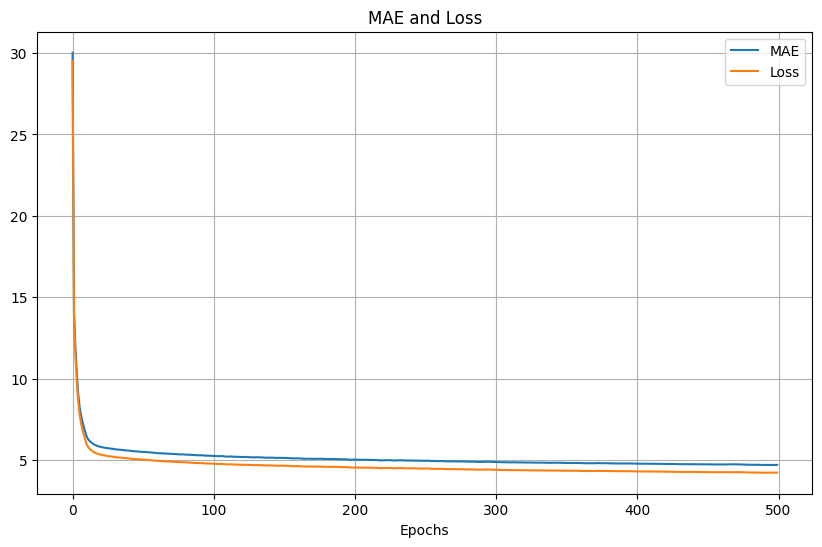

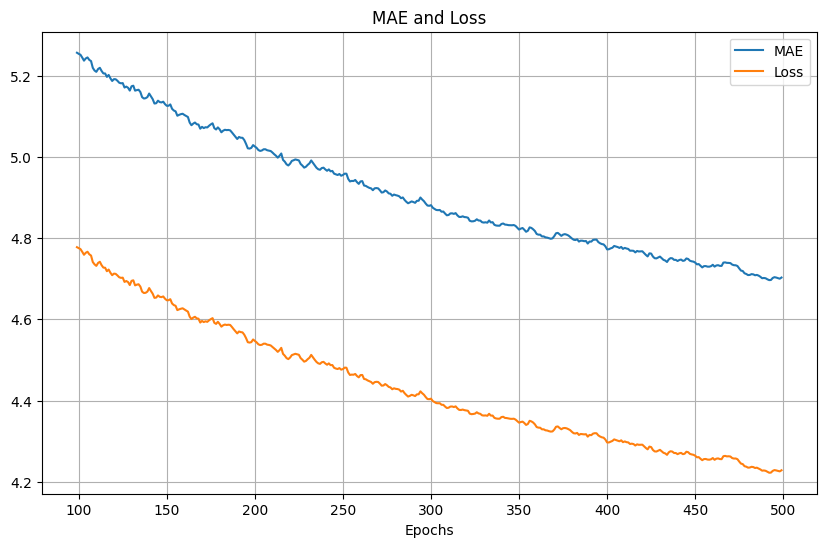

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

## Model Prediction

Once training is done, you can generate the model predictions and plot them against the validation set.


In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

W0000 00:00:1728583461.268909  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.278574  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.282069  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.286058  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.289344  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.292657  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.295981  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.299383  279739 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583461.302834  279739 gp

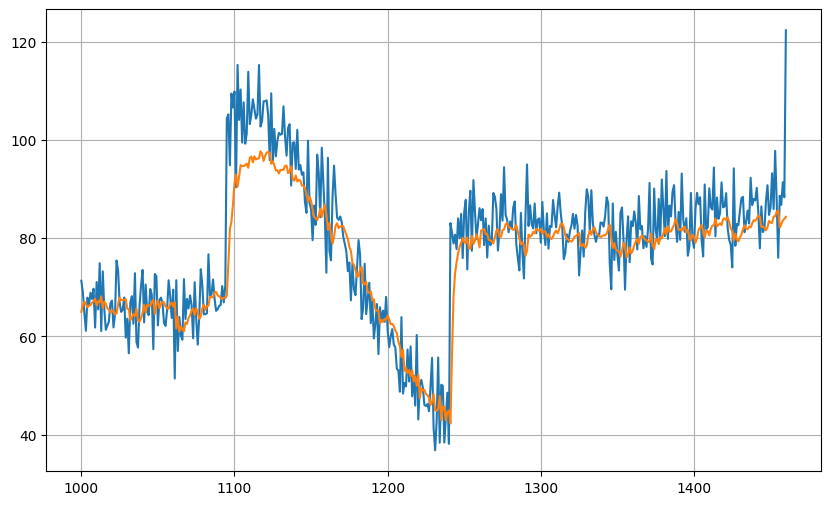

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the metrics as usual.

In [18]:
## Compute the MAE and MSE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

54.29344
5.3905535


## Wrap Up

In this lab, you were able to build and train a CNN-RNN model for forecasting. This concludes the series of notebooks on training with synthetic data. In the next labs, you will be looking at a real world time series dataset, particularly sunspot cycles. See you there!

If you won't explore the optional exercises below, please uncomment the cell below and run it to free up resources for the next labs.

In [19]:
# # Uncomment the code below if you will not explore the optional section.
# # Shutdown the kernel to free up resources. 
# # Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

# from IPython import get_ipython

# k = get_ipython().kernel

# k.do_shutdown(restart=False)

## Optional - Adding a Callback for Early Stopping

In this optional section, you will add a callback to stop training when a metric is met. You already did this in the first course of this specialization and now would be a good time to review.

First, you need to prepare a validation set that the model can use and monitor. As shown in the previous lab, you can use the `windowed_dataset()` function to prepare this.

In [20]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can reset the weights of the model or just continue from where you left off.

In [21]:
# Uncomment if you want to reset the weights
# model.set_weights(init_weights)

Next, you will define a callback function that is run every end of an epoch. Inside, you will define the condition to stop training. For this lab, you will set it to stop when the `val_mae` is less than `5.7`.

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.7):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

Remember to set an appropriate learning rate here. If you're starting from random weights, you may want to use the same rate you used earlier. If you did not reset the weights however, you can use a lower learning rate so the model can learn better. If all goes well, the training will stop before the set 500 epochs are completed.

In [23]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
     60/Unknown 1s 9ms/step - loss: 4.1289 - mae: 4.6040

2024-10-10 15:04:23.345785: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7607432125602951234
2024-10-10 15:04:23.345849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16897856607068635327
2024-10-10 15:04:23.345857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2051225101575728229
2024-10-10 15:04:23.345861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7747293733962466677
2024-10-10 15:04:23.345864: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14258238108885323115
2024-10-10 15:04:23.345869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15010343664563437886



Required val MAE is met so cancelling training!
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.1312 - mae: 4.6061 - val_loss: 5.1620 - val_mae: 5.6444


W0000 00:00:1728583463.754898  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.758644  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.761854  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.765086  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.768373  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.771580  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.774814  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.777989  279743 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583463.781196  279743 gp

In practice, you normally have a separate test set to evaluate against unseen data. For this exercise however, the dataset is already very small so let's just use the same validation set just to verify that the results are comparable to the one you got earlier.

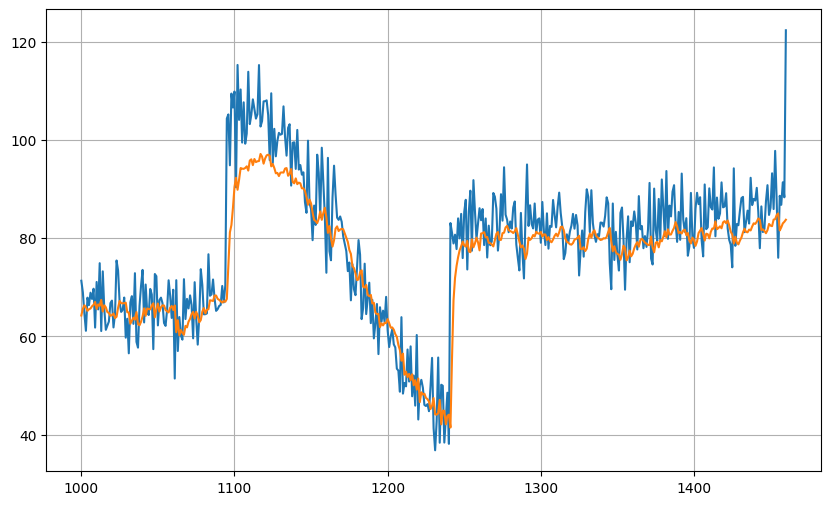

In [24]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

The computed metrics here will be slightly different from the one shown in the training output because it has more points to evaluate. Remember that `x_valid` has 461 points that corresponds to `t=1000` to `t=1460`. `val_set` (which is a windowed dataset from `x_valid`), on the other hand, only has 441 points because it cannot generate predictions for `t=1000` to `t=1019` (i.e. windowing will start there).

In [25]:
## Compute the MAE and MSE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

57.877422
5.562848


Run the cell below to free up resources for the next lab.

In [26]:
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}

: 